In [2]:
# Naive experiment for orientation detection 5/25
# --> nod_train.pkl과 nod_test.pkl에 (이미지 경로, 라벨) 데이터 들어 있습니다.

In [159]:
import os
from glob import glob
import re
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import pickle
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import timm
from adamp import AdamP

In [2]:
train_dir = '/opt/ml/input/data/train_dataset'
image_dir = '/opt/ml/input/data/train_dataset/images'

In [3]:
def read_info(filepath):
    col_name = os.path.basename(filepath).split('.')[0]
    df_info = pd.read_csv(filepath, delimiter='\t', header=None)
    df_info.columns = ['filename', col_name]
    return df_info

source_all = read_info(os.path.join(train_dir, 'source.txt'))
level_all = read_info(os.path.join(train_dir, 'level.txt'))
with open(os.path.join(train_dir, 'gt.txt')) as f:
    gt_all = pd.DataFrame({c: v for c, v in zip(['filename', 'gt'], zip(*map(lambda x: x.split('\t'), list(map(lambda x: x.strip(), f.readlines())))))})
with open(os.path.join(train_dir, 'tokens.txt')) as f:
    tokens_all = [x.strip() for x in f.readlines()]

In [4]:
def show_image(image_idx, show_gt=True):
    if isinstance(image_idx, int):
        image_path = os.path.join(train_dir, 'images', f'train_{image_idx:05d}.jpg')
    elif isinstance(image_idx, str):
        image_path = image_idx
        image_idx = int(re.findall('[0-9]{5}', image_idx)[0])
    else:
        raise ValueError
    print(image_path)
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    if show_gt:
        print(gt_all.iloc[image_idx, 1].split())
        
def idx_to_path(idx):
    return os.path.join(train_dir, "images", f"train_{idx:05d}.jpg")

### 데이터 가져오기

In [47]:
not_to_rotate = [(0.65625, '/opt/ml/input/data/train_dataset/images/train_12969.jpg'),
 (0.8813559322033898,
  '/opt/ml/input/data/train_dataset/images/train_18861.jpg'),
 (0.6774193548387096,
  '/opt/ml/input/data/train_dataset/images/train_46983.jpg'),
 (0.7758620689655172,
  '/opt/ml/input/data/train_dataset/images/train_86136.jpg'),
 (0.7453183520599251,
  '/opt/ml/input/data/train_dataset/images/train_15994.jpg'),
 (0.7142857142857143,
  '/opt/ml/input/data/train_dataset/images/train_43845.jpg'),
 (0.8958333333333334,
  '/opt/ml/input/data/train_dataset/images/train_16527.jpg'),
 (0.9044943820224719,
  '/opt/ml/input/data/train_dataset/images/train_77770.jpg'),
 (0.6475903614457831,
  '/opt/ml/input/data/train_dataset/images/train_68233.jpg'),
 (0.6888888888888889,
  '/opt/ml/input/data/train_dataset/images/train_10218.jpg'),
 (0.8271375464684015,
  '/opt/ml/input/data/train_dataset/images/train_16119.jpg'),
 (1.0, '/opt/ml/input/data/train_dataset/images/train_27959.jpg'),
 (0.765, '/opt/ml/input/data/train_dataset/images/train_99858.jpg'),
 (0.9438202247191011,
  '/opt/ml/input/data/train_dataset/images/train_61993.jpg'),
 (0.8823529411764706,
  '/opt/ml/input/data/train_dataset/images/train_27196.jpg'),
 (0.6764705882352942,
  '/opt/ml/input/data/train_dataset/images/train_13520.jpg'),
 (0.8426966292134831,
  '/opt/ml/input/data/train_dataset/images/train_55991.jpg'),
 (0.8863636363636364,
  '/opt/ml/input/data/train_dataset/images/train_49870.jpg'),
 (0.8571428571428571,
  '/opt/ml/input/data/train_dataset/images/train_60670.jpg'),
 (0.9, '/opt/ml/input/data/train_dataset/images/train_56753.jpg'),
 (0.88, '/opt/ml/input/data/train_dataset/images/train_34854.jpg'),
 (0.904891304347826,
  '/opt/ml/input/data/train_dataset/images/train_46510.jpg'),
 (1.0, '/opt/ml/input/data/train_dataset/images/train_98177.jpg'),
 (0.83125, '/opt/ml/input/data/train_dataset/images/train_71959.jpg'),
 (0.9125, '/opt/ml/input/data/train_dataset/images/train_69669.jpg'),
 (0.9230769230769231,
  '/opt/ml/input/data/train_dataset/images/train_01112.jpg'),
 (0.9591194968553459,
  '/opt/ml/input/data/train_dataset/images/train_14071.jpg'),
 (0.592741935483871,
  '/opt/ml/input/data/train_dataset/images/train_77975.jpg'),
 (0.6108949416342413,
  '/opt/ml/input/data/train_dataset/images/train_83051.jpg'),
 (0.6887755102040817,
  '/opt/ml/input/data/train_dataset/images/train_12835.jpg'),
 (0.9507772020725389,
  '/opt/ml/input/data/train_dataset/images/train_99290.jpg'),
 (0.85, '/opt/ml/input/data/train_dataset/images/train_58094.jpg'),
 (0.6256410256410256,
  '/opt/ml/input/data/train_dataset/images/train_05771.jpg'),
 (0.7790697674418605,
  '/opt/ml/input/data/train_dataset/images/train_58313.jpg'),
 (0.9714285714285714,
  '/opt/ml/input/data/train_dataset/images/train_74762.jpg'),
 (0.9299610894941635,
  '/opt/ml/input/data/train_dataset/images/train_36449.jpg'),
 (0.8290909090909091,
  '/opt/ml/input/data/train_dataset/images/train_52734.jpg'),
 (0.23741007194244604,
  '/opt/ml/input/data/train_dataset/images/train_00015.jpg'),
 (0.9111111111111111,
  '/opt/ml/input/data/train_dataset/images/train_80437.jpg'),
 (0.925531914893617,
  '/opt/ml/input/data/train_dataset/images/train_95700.jpg'),
 (0.7635135135135135,
  '/opt/ml/input/data/train_dataset/images/train_56811.jpg'),
 (0.749003984063745,
  '/opt/ml/input/data/train_dataset/images/train_73551.jpg'),
 (0.6709401709401709,
  '/opt/ml/input/data/train_dataset/images/train_77740.jpg'),
 (0.7881619937694704,
  '/opt/ml/input/data/train_dataset/images/train_27477.jpg'),
 (0.6369230769230769,
  '/opt/ml/input/data/train_dataset/images/train_82156.jpg'),
 (0.85, '/opt/ml/input/data/train_dataset/images/train_68285.jpg'),
 (0.9976958525345622,
  '/opt/ml/input/data/train_dataset/images/train_84100.jpg'),
 (0.9821428571428571,
  '/opt/ml/input/data/train_dataset/images/train_14046.jpg'),
 (0.90625, '/opt/ml/input/data/train_dataset/images/train_88991.jpg'),
 (0.9893048128342246,
  '/opt/ml/input/data/train_dataset/images/train_12822.jpg'),
 (0.9556313993174061,
  '/opt/ml/input/data/train_dataset/images/train_67252.jpg'),
 (0.9851190476190477,
  '/opt/ml/input/data/train_dataset/images/train_03103.jpg'),
 (0.9586374695863747,
  '/opt/ml/input/data/train_dataset/images/train_80794.jpg'),
 (0.8333333333333334,
  '/opt/ml/input/data/train_dataset/images/train_24637.jpg'),
 (0.8113207547169812,
  '/opt/ml/input/data/train_dataset/images/train_77420.jpg'),
 (0.5714285714285714,
  '/opt/ml/input/data/train_dataset/images/train_83711.jpg'),
 (1.0, '/opt/ml/input/data/train_dataset/images/train_88414.jpg'),
 (1.0, '/opt/ml/input/data/train_dataset/images/train_68873.jpg'),
 (0.512396694214876,
  '/opt/ml/input/data/train_dataset/images/train_48526.jpg'),
 (0.9403669724770642,
  '/opt/ml/input/data/train_dataset/images/train_57634.jpg'),
 (0.7454545454545455,
  '/opt/ml/input/data/train_dataset/images/train_03344.jpg'),
 (0.6535269709543569,
  '/opt/ml/input/data/train_dataset/images/train_48802.jpg'),
 (0.8181818181818182,
  '/opt/ml/input/data/train_dataset/images/train_17114.jpg'),
 (0.63, '/opt/ml/input/data/train_dataset/images/train_51541.jpg'),
 (0.7727272727272727,
  '/opt/ml/input/data/train_dataset/images/train_19898.jpg'),
 (0.864406779661017,
  '/opt/ml/input/data/train_dataset/images/train_66284.jpg'),
 (0.8697068403908795,
  '/opt/ml/input/data/train_dataset/images/train_71815.jpg'),
 (0.9398496240601504,
  '/opt/ml/input/data/train_dataset/images/train_58559.jpg'),
 (0.7645161290322581,
  '/opt/ml/input/data/train_dataset/images/train_62706.jpg'),
 (1.0, '/opt/ml/input/data/train_dataset/images/train_86441.jpg'),
 (0.5985401459854015,
  '/opt/ml/input/data/train_dataset/images/train_21454.jpg'),
 (0.7146596858638743,
  '/opt/ml/input/data/train_dataset/images/train_38161.jpg'),
 (0.6750788643533123,
  '/opt/ml/input/data/train_dataset/images/train_68211.jpg'),
 (0.9302325581395349,
  '/opt/ml/input/data/train_dataset/images/train_71043.jpg'),
 (0.9230769230769231,
  '/opt/ml/input/data/train_dataset/images/train_62163.jpg'),
 (0.66875, '/opt/ml/input/data/train_dataset/images/train_59794.jpg'),
 (0.9943977591036415,
  '/opt/ml/input/data/train_dataset/images/train_79799.jpg'),
 (1.0, '/opt/ml/input/data/train_dataset/images/train_40924.jpg'),
 (0.8421052631578947,
  '/opt/ml/input/data/train_dataset/images/train_80562.jpg'),
 (0.7984790874524715,
  '/opt/ml/input/data/train_dataset/images/train_55914.jpg'),
 (0.9917695473251029,
  '/opt/ml/input/data/train_dataset/images/train_41433.jpg'),
 (1.0, '/opt/ml/input/data/train_dataset/images/train_41909.jpg'),
 (0.7475728155339806,
  '/opt/ml/input/data/train_dataset/images/train_31968.jpg'),
 (0.9122807017543859,
  '/opt/ml/input/data/train_dataset/images/train_45567.jpg'),
 (0.7110091743119266,
  '/opt/ml/input/data/train_dataset/images/train_19040.jpg'),
 (0.6928571428571428,
  '/opt/ml/input/data/train_dataset/images/train_34981.jpg'),
 (1.0, '/opt/ml/input/data/train_dataset/images/train_07562.jpg'),
 (0.9386503067484663,
  '/opt/ml/input/data/train_dataset/images/train_35969.jpg'),
 (1.0, '/opt/ml/input/data/train_dataset/images/train_30756.jpg'),
 (0.9794721407624634,
  '/opt/ml/input/data/train_dataset/images/train_78147.jpg'),
 (0.9230769230769231,
  '/opt/ml/input/data/train_dataset/images/train_01619.jpg'),
 (0.7837837837837838,
  '/opt/ml/input/data/train_dataset/images/train_98950.jpg'),
 (0.7816091954022989,
  '/opt/ml/input/data/train_dataset/images/train_93008.jpg'),
 (0.7993630573248408,
  '/opt/ml/input/data/train_dataset/images/train_35979.jpg'),
 (0.5653710247349824,
  '/opt/ml/input/data/train_dataset/images/train_53868.jpg'),
 (0.9078341013824884,
  '/opt/ml/input/data/train_dataset/images/train_61841.jpg'),
 (0.9453125, '/opt/ml/input/data/train_dataset/images/train_01923.jpg'),
 (0.9760765550239234,
  '/opt/ml/input/data/train_dataset/images/train_17131.jpg'),
 (0.9864864864864865,
  '/opt/ml/input/data/train_dataset/images/train_04899.jpg'),
 (0.7567567567567568,
  '/opt/ml/input/data/train_dataset/images/train_85903.jpg'),
 (0.949343339587242,
  '/opt/ml/input/data/train_dataset/images/train_48813.jpg'),
 (0.8410596026490066,
  '/opt/ml/input/data/train_dataset/images/train_07580.jpg'),
 (0.9387755102040817,
  '/opt/ml/input/data/train_dataset/images/train_69025.jpg'),
 (0.9404255319148936,
  '/opt/ml/input/data/train_dataset/images/train_34743.jpg'),
 (0.9847328244274809,
  '/opt/ml/input/data/train_dataset/images/train_11746.jpg'),
 (1.0, '/opt/ml/input/data/train_dataset/images/train_63960.jpg'),
 (0.6160877513711152,
  '/opt/ml/input/data/train_dataset/images/train_07829.jpg'),
 (0.837173579109063,
  '/opt/ml/input/data/train_dataset/images/train_25314.jpg'),
 (0.9249146757679181,
  '/opt/ml/input/data/train_dataset/images/train_32112.jpg'),
 (0.9782608695652174,
  '/opt/ml/input/data/train_dataset/images/train_54312.jpg'),
 (0.8322496749024707,
  '/opt/ml/input/data/train_dataset/images/train_61736.jpg'),
 (0.8992248062015504,
  '/opt/ml/input/data/train_dataset/images/train_95473.jpg'),
 (0.7256317689530686,
  '/opt/ml/input/data/train_dataset/images/train_49630.jpg'),
 (0.9512195121951219,
  '/opt/ml/input/data/train_dataset/images/train_04005.jpg'),
 (0.925531914893617,
  '/opt/ml/input/data/train_dataset/images/train_51697.jpg'),
 (0.8461538461538461,
  '/opt/ml/input/data/train_dataset/images/train_65384.jpg'),
 (0.7741935483870968,
  '/opt/ml/input/data/train_dataset/images/train_94331.jpg'),
 (0.7621776504297995,
  '/opt/ml/input/data/train_dataset/images/train_80418.jpg'),
 (0.7372708757637475,
  '/opt/ml/input/data/train_dataset/images/train_43863.jpg'),
 (0.890295358649789,
  '/opt/ml/input/data/train_dataset/images/train_29098.jpg'),
 (0.5984848484848485,
  '/opt/ml/input/data/train_dataset/images/train_83951.jpg'),
 (0.92, '/opt/ml/input/data/train_dataset/images/train_17474.jpg'),
 (0.9673469387755103,
  '/opt/ml/input/data/train_dataset/images/train_77822.jpg'),
 (0.9590163934426229,
  '/opt/ml/input/data/train_dataset/images/train_46627.jpg'),
 (0.8248587570621468,
  '/opt/ml/input/data/train_dataset/images/train_63845.jpg'),
 (0.8496732026143791,
  '/opt/ml/input/data/train_dataset/images/train_04459.jpg'),
 (0.7837837837837838,
  '/opt/ml/input/data/train_dataset/images/train_82054.jpg'),
 (0.9278350515463918,
  '/opt/ml/input/data/train_dataset/images/train_18437.jpg'),
 (0.7010869565217391,
  '/opt/ml/input/data/train_dataset/images/train_43217.jpg'),
 (0.7652582159624414,
  '/opt/ml/input/data/train_dataset/images/train_82834.jpg'),
 (0.8623737373737373,
  '/opt/ml/input/data/train_dataset/images/train_79019.jpg'),
 (0.7523219814241486,
  '/opt/ml/input/data/train_dataset/images/train_09529.jpg'),
 (0.8677685950413223,
  '/opt/ml/input/data/train_dataset/images/train_68928.jpg'),
 (0.7326732673267327,
  '/opt/ml/input/data/train_dataset/images/train_83741.jpg'),
 (0.8269230769230769,
  '/opt/ml/input/data/train_dataset/images/train_67677.jpg'),
 (0.9694117647058823,
  '/opt/ml/input/data/train_dataset/images/train_30607.jpg'),
 (0.9127906976744186,
  '/opt/ml/input/data/train_dataset/images/train_42239.jpg'),
 (0.9201680672268907,
  '/opt/ml/input/data/train_dataset/images/train_23087.jpg'),
 (0.7545126353790613,
  '/opt/ml/input/data/train_dataset/images/train_25180.jpg'),
 (0.8367346938775511,
  '/opt/ml/input/data/train_dataset/images/train_52094.jpg'),
 (0.9741176470588235,
  '/opt/ml/input/data/train_dataset/images/train_40214.jpg'),
 (0.8923076923076924,
  '/opt/ml/input/data/train_dataset/images/train_18302.jpg'),
 (0.950920245398773,
  '/opt/ml/input/data/train_dataset/images/train_05442.jpg'),
 (0.9009009009009009,
  '/opt/ml/input/data/train_dataset/images/train_78988.jpg'),
 (0.9959595959595959,
  '/opt/ml/input/data/train_dataset/images/train_70028.jpg'),
 (0.9534883720930233,
  '/opt/ml/input/data/train_dataset/images/train_81026.jpg'),
 (0.7333333333333333,
  '/opt/ml/input/data/train_dataset/images/train_78867.jpg'),
 (0.8327645051194539,
  '/opt/ml/input/data/train_dataset/images/train_96280.jpg'),
 (0.9532497149372862,
  '/opt/ml/input/data/train_dataset/images/train_65428.jpg'),
 (0.6869565217391305,
  '/opt/ml/input/data/train_dataset/images/train_95322.jpg'),
 (0.8199052132701422,
  '/opt/ml/input/data/train_dataset/images/train_33776.jpg'),
 (0.7470588235294118,
  '/opt/ml/input/data/train_dataset/images/train_14765.jpg'),
 (0.8153846153846154,
  '/opt/ml/input/data/train_dataset/images/train_84306.jpg'),
 (0.990909090909091,
  '/opt/ml/input/data/train_dataset/images/train_15487.jpg'),
 (0.9878296146044625,
  '/opt/ml/input/data/train_dataset/images/train_53670.jpg'),
 (0.6230366492146597,
  '/opt/ml/input/data/train_dataset/images/train_72437.jpg'),
 (0.8520710059171598,
  '/opt/ml/input/data/train_dataset/images/train_79302.jpg'),
 (0.9644268774703557,
  '/opt/ml/input/data/train_dataset/images/train_81817.jpg'),
 (1.0, '/opt/ml/input/data/train_dataset/images/train_75114.jpg'),
 (0.8716577540106952,
  '/opt/ml/input/data/train_dataset/images/train_71722.jpg'),
 (0.7881773399014779,
  '/opt/ml/input/data/train_dataset/images/train_25937.jpg'),
 (0.944078947368421,
  '/opt/ml/input/data/train_dataset/images/train_77935.jpg'),
 (0.9522842639593908,
  '/opt/ml/input/data/train_dataset/images/train_86513.jpg'),
 (0.828125, '/opt/ml/input/data/train_dataset/images/train_34896.jpg'),
 (0.884469696969697,
  '/opt/ml/input/data/train_dataset/images/train_04661.jpg'),
 (0.7801724137931034,
  '/opt/ml/input/data/train_dataset/images/train_84130.jpg'),
 (0.9896551724137931,
  '/opt/ml/input/data/train_dataset/images/train_61429.jpg'),
 (0.993127147766323,
  '/opt/ml/input/data/train_dataset/images/train_84381.jpg'),
 (0.9395973154362416,
  '/opt/ml/input/data/train_dataset/images/train_95165.jpg'),
 (0.7490196078431373,
  '/opt/ml/input/data/train_dataset/images/train_65402.jpg'),
 (0.9861111111111112,
  '/opt/ml/input/data/train_dataset/images/train_20653.jpg'),
 (0.9886792452830189,
  '/opt/ml/input/data/train_dataset/images/train_31157.jpg'),
 (0.7433155080213903,
  '/opt/ml/input/data/train_dataset/images/train_29458.jpg'),
 (0.9425287356321839,
  '/opt/ml/input/data/train_dataset/images/train_18909.jpg'),
 (0.8604651162790697,
  '/opt/ml/input/data/train_dataset/images/train_03465.jpg'),
 (0.8935574229691877,
  '/opt/ml/input/data/train_dataset/images/train_33349.jpg'),
 (0.8604651162790697,
  '/opt/ml/input/data/train_dataset/images/train_75585.jpg'),
 (0.9629629629629629,
  '/opt/ml/input/data/train_dataset/images/train_91387.jpg'),
 (0.9797297297297297,
  '/opt/ml/input/data/train_dataset/images/train_56489.jpg'),
 (0.9607843137254902,
  '/opt/ml/input/data/train_dataset/images/train_32446.jpg'),
 (0.9672897196261683,
  '/opt/ml/input/data/train_dataset/images/train_11353.jpg'),
 (0.7781065088757396,
  '/opt/ml/input/data/train_dataset/images/train_89168.jpg'),
 (0.96875, '/opt/ml/input/data/train_dataset/images/train_46297.jpg'),
 (0.717948717948718,
  '/opt/ml/input/data/train_dataset/images/train_08486.jpg'),
 (0.890625, '/opt/ml/input/data/train_dataset/images/train_07419.jpg'),
 (0.49019607843137253,
  '/opt/ml/input/data/train_dataset/images/train_18429.jpg'),
 (0.8373983739837398,
  '/opt/ml/input/data/train_dataset/images/train_68376.jpg'),
 (1.0, '/opt/ml/input/data/train_dataset/images/train_50709.jpg'),
 (0.6871508379888268,
  '/opt/ml/input/data/train_dataset/images/train_37366.jpg'),
 (0.7986348122866894,
  '/opt/ml/input/data/train_dataset/images/train_15724.jpg'),
 (0.8979591836734694,
  '/opt/ml/input/data/train_dataset/images/train_40660.jpg'),
 (0.9444444444444444,
  '/opt/ml/input/data/train_dataset/images/train_39562.jpg'),
 (0.7991111111111111,
  '/opt/ml/input/data/train_dataset/images/train_01299.jpg'),
 (0.9230769230769231,
  '/opt/ml/input/data/train_dataset/images/train_01299.jpg'),
 (0.8077803203661327,
  '/opt/ml/input/data/train_dataset/images/train_63264.jpg'),
 (0.788235294117647,
  '/opt/ml/input/data/train_dataset/images/train_14885.jpg'),
 (0.9875, '/opt/ml/input/data/train_dataset/images/train_53533.jpg'),
 (0.91005291005291, '/opt/ml/input/data/train_dataset/images/train_24469.jpg'),
 (0.9966887417218543,
  '/opt/ml/input/data/train_dataset/images/train_05255.jpg'),
 (0.6580645161290323,
  '/opt/ml/input/data/train_dataset/images/train_72726.jpg'),
 (0.8699186991869918,
  '/opt/ml/input/data/train_dataset/images/train_74415.jpg'),
 (0.9459459459459459,
  '/opt/ml/input/data/train_dataset/images/train_77312.jpg'),
 (0.9404761904761905,
  '/opt/ml/input/data/train_dataset/images/train_97199.jpg'),
 (0.92, '/opt/ml/input/data/train_dataset/images/train_33037.jpg'),
 (1.0, '/opt/ml/input/data/train_dataset/images/train_60568.jpg'),
 (0.8518518518518519,
  '/opt/ml/input/data/train_dataset/images/train_16874.jpg'),
 (0.7836538461538461,
  '/opt/ml/input/data/train_dataset/images/train_13390.jpg'),
 (1.0, '/opt/ml/input/data/train_dataset/images/train_67085.jpg'),
 (0.40418118466898956,
  '/opt/ml/input/data/train_dataset/images/train_66791.jpg'),
 (0.9565217391304348,
  '/opt/ml/input/data/train_dataset/images/train_12309.jpg'),
 (0.6555, '/opt/ml/input/data/train_dataset/images/train_71436.jpg'),
 (0.7241379310344828,
  '/opt/ml/input/data/train_dataset/images/train_57201.jpg'),
 (0.9877300613496932,
  '/opt/ml/input/data/train_dataset/images/train_18739.jpg'),
 (0.9454545454545454,
  '/opt/ml/input/data/train_dataset/images/train_74822.jpg'),
 (0.8050847457627118,
  '/opt/ml/input/data/train_dataset/images/train_55406.jpg'),
 (0.7464788732394366,
  '/opt/ml/input/data/train_dataset/images/train_68576.jpg'),
 (0.7987355110642782,
  '/opt/ml/input/data/train_dataset/images/train_08730.jpg'),
 (0.29464285714285715,
  '/opt/ml/input/data/train_dataset/images/train_94449.jpg'),
 (0.9860557768924303,
  '/opt/ml/input/data/train_dataset/images/train_27455.jpg'),
 (0.9773635153129161,
  '/opt/ml/input/data/train_dataset/images/train_94485.jpg'),
 (0.7507692307692307,
  '/opt/ml/input/data/train_dataset/images/train_90955.jpg'),
 (0.6805555555555556,
  '/opt/ml/input/data/train_dataset/images/train_78264.jpg'),
 (0.8050314465408805,
  '/opt/ml/input/data/train_dataset/images/train_57225.jpg'),
 (0.9541284403669725,
  '/opt/ml/input/data/train_dataset/images/train_26194.jpg'),
 (1.0, '/opt/ml/input/data/train_dataset/images/train_77860.jpg'),
 (0.7845744680851063,
  '/opt/ml/input/data/train_dataset/images/train_99788.jpg'),
 (0.8401559454191033,
  '/opt/ml/input/data/train_dataset/images/train_98021.jpg'),
 (0.7241379310344828,
  '/opt/ml/input/data/train_dataset/images/train_61356.jpg'),
 (0.7773279352226721,
  '/opt/ml/input/data/train_dataset/images/train_65269.jpg'),
 (0.7137254901960784,
  '/opt/ml/input/data/train_dataset/images/train_74930.jpg'),
 (0.8571428571428571,
  '/opt/ml/input/data/train_dataset/images/train_02140.jpg'),
 (1.0, '/opt/ml/input/data/train_dataset/images/train_18687.jpg'),
 (0.7746478873239436,
  '/opt/ml/input/data/train_dataset/images/train_53523.jpg'),
 (0.6407563025210085,
  '/opt/ml/input/data/train_dataset/images/train_78859.jpg'),
 (0.8114035087719298,
  '/opt/ml/input/data/train_dataset/images/train_25144.jpg'),
 (0.9906976744186047,
  '/opt/ml/input/data/train_dataset/images/train_47853.jpg'),
 (0.6724738675958188,
  '/opt/ml/input/data/train_dataset/images/train_18048.jpg'),
 (0.5484581497797357,
  '/opt/ml/input/data/train_dataset/images/train_92871.jpg'),
 (0.6476190476190476,
  '/opt/ml/input/data/train_dataset/images/train_18073.jpg'),
 (0.711864406779661,
  '/opt/ml/input/data/train_dataset/images/train_90062.jpg'),
 (0.9349112426035503,
  '/opt/ml/input/data/train_dataset/images/train_95402.jpg'),
 (0.6493055555555556,
  '/opt/ml/input/data/train_dataset/images/train_03962.jpg'),
 (1.0, '/opt/ml/input/data/train_dataset/images/train_28855.jpg'),
 (0.6890459363957597,
  '/opt/ml/input/data/train_dataset/images/train_49286.jpg'),
 (0.8593350383631714,
  '/opt/ml/input/data/train_dataset/images/train_20899.jpg'),
 (0.8703703703703703,
  '/opt/ml/input/data/train_dataset/images/train_29298.jpg'),
 (1.0, '/opt/ml/input/data/train_dataset/images/train_11558.jpg'),
 (0.956989247311828,
  '/opt/ml/input/data/train_dataset/images/train_85449.jpg'),
 (0.3333333333333333,
  '/opt/ml/input/data/train_dataset/images/train_77432.jpg'),
 (0.7514619883040936,
  '/opt/ml/input/data/train_dataset/images/train_66221.jpg'),
 (0.6619047619047619,
  '/opt/ml/input/data/train_dataset/images/train_41184.jpg'),
 (0.9666666666666667,
  '/opt/ml/input/data/train_dataset/images/train_06810.jpg'),
 (0.9795918367346939,
  '/opt/ml/input/data/train_dataset/images/train_21245.jpg'),
 (0.9795918367346939,
  '/opt/ml/input/data/train_dataset/images/train_30689.jpg'),
 (1.0, '/opt/ml/input/data/train_dataset/images/train_39754.jpg'),
 (0.5471698113207547,
  '/opt/ml/input/data/train_dataset/images/train_12389.jpg'),
 (0.6666666666666666,
  '/opt/ml/input/data/train_dataset/images/train_56128.jpg'),
 (0.9240780911062907,
  '/opt/ml/input/data/train_dataset/images/train_26842.jpg'),
 (0.6811145510835913,
  '/opt/ml/input/data/train_dataset/images/train_43921.jpg'),
 (0.972972972972973,
  '/opt/ml/input/data/train_dataset/images/train_19829.jpg'),
 (0.9920948616600791,
  '/opt/ml/input/data/train_dataset/images/train_88976.jpg'),
 (0.7065217391304348,
  '/opt/ml/input/data/train_dataset/images/train_48217.jpg'),
 (0.8622448979591837,
  '/opt/ml/input/data/train_dataset/images/train_86616.jpg'),
 (1.0, '/opt/ml/input/data/train_dataset/images/train_15512.jpg'),
 (0.7235294117647059,
  '/opt/ml/input/data/train_dataset/images/train_91808.jpg'),
 (0.9455445544554455,
  '/opt/ml/input/data/train_dataset/images/train_05914.jpg'),
 (0.9230769230769231,
  '/opt/ml/input/data/train_dataset/images/train_75829.jpg'),
 (0.6212121212121212,
  '/opt/ml/input/data/train_dataset/images/train_54912.jpg'),
 (0.9411764705882353,
  '/opt/ml/input/data/train_dataset/images/train_35889.jpg'),
 (1.0, '/opt/ml/input/data/train_dataset/images/train_70950.jpg'),
 (0.831858407079646,
  '/opt/ml/input/data/train_dataset/images/train_85456.jpg'),
 (0.7767857142857143,
  '/opt/ml/input/data/train_dataset/images/train_41678.jpg'),
 (0.6581986143187067,
  '/opt/ml/input/data/train_dataset/images/train_69718.jpg'),
 (0.6944444444444444,
  '/opt/ml/input/data/train_dataset/images/train_42713.jpg'),
 (0.2903225806451613,
  '/opt/ml/input/data/train_dataset/images/train_04441.jpg'),
 (0.8984375, '/opt/ml/input/data/train_dataset/images/train_43473.jpg'),
 (0.9393939393939394,
  '/opt/ml/input/data/train_dataset/images/train_23206.jpg'),
 (0.7984790874524715,
  '/opt/ml/input/data/train_dataset/images/train_67724.jpg'),
 (0.6944444444444444,
  '/opt/ml/input/data/train_dataset/images/train_36982.jpg'),
 (0.9450651769087524,
  '/opt/ml/input/data/train_dataset/images/train_86296.jpg'),
 (0.7991360691144709,
  '/opt/ml/input/data/train_dataset/images/train_76975.jpg'),
 (0.8571428571428571,
  '/opt/ml/input/data/train_dataset/images/train_30364.jpg'),
 (0.7962962962962963,
  '/opt/ml/input/data/train_dataset/images/train_44192.jpg'),
 (0.7352380952380952,
  '/opt/ml/input/data/train_dataset/images/train_48398.jpg'),
 (0.9513888888888888,
  '/opt/ml/input/data/train_dataset/images/train_07209.jpg'),
 (0.7371273712737128,
  '/opt/ml/input/data/train_dataset/images/train_75032.jpg'),
 (0.6263345195729537,
  '/opt/ml/input/data/train_dataset/images/train_29940.jpg'),
 (0.9438596491228071,
  '/opt/ml/input/data/train_dataset/images/train_14810.jpg'),
 (1.0, '/opt/ml/input/data/train_dataset/images/train_18528.jpg'),
 (0.7914438502673797,
  '/opt/ml/input/data/train_dataset/images/train_58051.jpg'),
 (0.9690721649484536,
  '/opt/ml/input/data/train_dataset/images/train_97218.jpg'),
 (0.904296875, '/opt/ml/input/data/train_dataset/images/train_52943.jpg'),
 (0.896551724137931,
  '/opt/ml/input/data/train_dataset/images/train_61039.jpg'),
 (0.71334214002642, '/opt/ml/input/data/train_dataset/images/train_20038.jpg'),
 (0.925, '/opt/ml/input/data/train_dataset/images/train_28102.jpg'),
 (0.8925, '/opt/ml/input/data/train_dataset/images/train_70396.jpg'),
 (0.8, '/opt/ml/input/data/train_dataset/images/train_02832.jpg'),
 (0.9644268774703557,
  '/opt/ml/input/data/train_dataset/images/train_15630.jpg'),
 (0.9885496183206107,
  '/opt/ml/input/data/train_dataset/images/train_71405.jpg'),
 (0.9025270758122743,
  '/opt/ml/input/data/train_dataset/images/train_17184.jpg'),
 (1.0, '/opt/ml/input/data/train_dataset/images/train_55323.jpg'),
 (0.8807947019867549,
  '/opt/ml/input/data/train_dataset/images/train_20533.jpg'),
 (0.9420289855072463,
  '/opt/ml/input/data/train_dataset/images/train_57068.jpg'),
 (1.0, '/opt/ml/input/data/train_dataset/images/train_98101.jpg'),
 (0.7269503546099291,
  '/opt/ml/input/data/train_dataset/images/train_05867.jpg'),
 (0.6666666666666666,
  '/opt/ml/input/data/train_dataset/images/train_07319.jpg'),
 (0.6446280991735537,
  '/opt/ml/input/data/train_dataset/images/train_90100.jpg'),
 (1.0, '/opt/ml/input/data/train_dataset/images/train_38294.jpg'),
 (0.6314779270633397,
  '/opt/ml/input/data/train_dataset/images/train_49443.jpg'),
 (0.7095435684647303,
  '/opt/ml/input/data/train_dataset/images/train_59972.jpg'),
 (0.9730941704035875,
  '/opt/ml/input/data/train_dataset/images/train_69208.jpg'),
 (0.95, '/opt/ml/input/data/train_dataset/images/train_18469.jpg'),
 (0.7872340425531915,
  '/opt/ml/input/data/train_dataset/images/train_36284.jpg'),
 (0.6434782608695652,
  '/opt/ml/input/data/train_dataset/images/train_24312.jpg'),
 (0.7928994082840237,
  '/opt/ml/input/data/train_dataset/images/train_34955.jpg'),
 (0.8214285714285714,
  '/opt/ml/input/data/train_dataset/images/train_10549.jpg'),
 (0.9347368421052632,
  '/opt/ml/input/data/train_dataset/images/train_32538.jpg'),
 (0.8432055749128919,
  '/opt/ml/input/data/train_dataset/images/train_53534.jpg'),
 (0.9723926380368099,
  '/opt/ml/input/data/train_dataset/images/train_25924.jpg'),
 (0.9431578947368421,
  '/opt/ml/input/data/train_dataset/images/train_80783.jpg'),
 (0.49678800856531047,
  '/opt/ml/input/data/train_dataset/images/train_64989.jpg'),
 (0.7335907335907336,
  '/opt/ml/input/data/train_dataset/images/train_10547.jpg'),
 (0.8095238095238095,
  '/opt/ml/input/data/train_dataset/images/train_41635.jpg'),
 (0.6829268292682927,
  '/opt/ml/input/data/train_dataset/images/train_65924.jpg'),
 (0.7932816537467701,
  '/opt/ml/input/data/train_dataset/images/train_65249.jpg'),
 (0.9833795013850416,
  '/opt/ml/input/data/train_dataset/images/train_74982.jpg'),
 (0.708171206225681,
  '/opt/ml/input/data/train_dataset/images/train_64033.jpg'),
 (0.6875, '/opt/ml/input/data/train_dataset/images/train_40451.jpg'),
 (0.562015503875969,
  '/opt/ml/input/data/train_dataset/images/train_77370.jpg'),
 (0.9277777777777778,
  '/opt/ml/input/data/train_dataset/images/train_42646.jpg'),
 (0.9530612244897959,
  '/opt/ml/input/data/train_dataset/images/train_42015.jpg'),
 (0.7012987012987013,
  '/opt/ml/input/data/train_dataset/images/train_31161.jpg'),
 (0.8604651162790697,
  '/opt/ml/input/data/train_dataset/images/train_01619.jpg'),
 (0.9837837837837838,
  '/opt/ml/input/data/train_dataset/images/train_39705.jpg'),
 (0.8823529411764706,
  '/opt/ml/input/data/train_dataset/images/train_59599.jpg'),
 (0.9191919191919192,
  '/opt/ml/input/data/train_dataset/images/train_88105.jpg'),
 (0.7681660899653979,
  '/opt/ml/input/data/train_dataset/images/train_76494.jpg'),
 (0.9117043121149897,
  '/opt/ml/input/data/train_dataset/images/train_80674.jpg'),
 (0.9014084507042254,
  '/opt/ml/input/data/train_dataset/images/train_67728.jpg'),
 (0.8656716417910447,
  '/opt/ml/input/data/train_dataset/images/train_88735.jpg'),
 (0.8620037807183365,
  '/opt/ml/input/data/train_dataset/images/train_84677.jpg'),
 (0.935064935064935,
  '/opt/ml/input/data/train_dataset/images/train_56708.jpg'),
 (0.990990990990991,
  '/opt/ml/input/data/train_dataset/images/train_71182.jpg'),
 (0.75, '/opt/ml/input/data/train_dataset/images/train_37844.jpg'),
 (0.8467532467532467,
  '/opt/ml/input/data/train_dataset/images/train_42321.jpg'),
 (0.8584070796460177,
  '/opt/ml/input/data/train_dataset/images/train_72071.jpg'),
 (0.9542857142857143,
  '/opt/ml/input/data/train_dataset/images/train_77251.jpg'),
 (0.9370629370629371,
  '/opt/ml/input/data/train_dataset/images/train_41053.jpg'),
 (0.9583333333333334,
  '/opt/ml/input/data/train_dataset/images/train_47902.jpg'),
 (0.8165680473372781,
  '/opt/ml/input/data/train_dataset/images/train_29080.jpg'),
 (0.8202247191011236,
  '/opt/ml/input/data/train_dataset/images/train_11429.jpg'),
 (0.9970059880239521,
  '/opt/ml/input/data/train_dataset/images/train_37888.jpg'),
 (0.5093945720250522,
  '/opt/ml/input/data/train_dataset/images/train_47957.jpg'),
 (0.7941176470588235,
  '/opt/ml/input/data/train_dataset/images/train_93116.jpg'),
 (0.7949790794979079,
  '/opt/ml/input/data/train_dataset/images/train_97895.jpg'),
 (0.9742489270386266,
  '/opt/ml/input/data/train_dataset/images/train_65452.jpg'),
 (0.9591836734693877,
  '/opt/ml/input/data/train_dataset/images/train_10499.jpg'),
 (0.9945054945054945,
  '/opt/ml/input/data/train_dataset/images/train_15933.jpg'),
 (0.958904109589041,
  '/opt/ml/input/data/train_dataset/images/train_73689.jpg'),
 (0.8317460317460318,
  '/opt/ml/input/data/train_dataset/images/train_35245.jpg'),
 (0.8079268292682927,
  '/opt/ml/input/data/train_dataset/images/train_89904.jpg'),
 (0.5814814814814815,
  '/opt/ml/input/data/train_dataset/images/train_79934.jpg'),
 (0.6772009029345373,
  '/opt/ml/input/data/train_dataset/images/train_53644.jpg'),
 (0.8746268656716418,
  '/opt/ml/input/data/train_dataset/images/train_39669.jpg'),
 (0.9615384615384616,
  '/opt/ml/input/data/train_dataset/images/train_32036.jpg'),
 (0.7904761904761904,
  '/opt/ml/input/data/train_dataset/images/train_79990.jpg'),
 (0.6944444444444444,
  '/opt/ml/input/data/train_dataset/images/train_20295.jpg'),
 (0.8951965065502183,
  '/opt/ml/input/data/train_dataset/images/train_10577.jpg'),
 (0.9575757575757575,
  '/opt/ml/input/data/train_dataset/images/train_19146.jpg'),
 (0.892018779342723,
  '/opt/ml/input/data/train_dataset/images/train_01112.jpg'),
 (0.9540229885057471,
  '/opt/ml/input/data/train_dataset/images/train_51734.jpg'),
 (0.6428571428571429,
  '/opt/ml/input/data/train_dataset/images/train_08790.jpg'),
 (0.7610921501706485,
  '/opt/ml/input/data/train_dataset/images/train_26839.jpg'),
 (0.8181818181818182,
  '/opt/ml/input/data/train_dataset/images/train_45219.jpg'),
 (0.6666666666666666,
  '/opt/ml/input/data/train_dataset/images/train_62344.jpg'),
 (0.7714285714285715,
  '/opt/ml/input/data/train_dataset/images/train_41600.jpg'),
 (0.7972560975609756,
  '/opt/ml/input/data/train_dataset/images/train_77707.jpg'),
 (0.9137931034482759,
  '/opt/ml/input/data/train_dataset/images/train_88082.jpg'),
 (0.9231678486997635,
  '/opt/ml/input/data/train_dataset/images/train_43897.jpg'),
 (0.7894736842105263,
  '/opt/ml/input/data/train_dataset/images/train_02210.jpg'),
 (0.9390986601705238,
  '/opt/ml/input/data/train_dataset/images/train_17206.jpg'),
 (0.9885931558935361,
  '/opt/ml/input/data/train_dataset/images/train_38913.jpg'),
 (0.9344262295081968,
  '/opt/ml/input/data/train_dataset/images/train_74461.jpg'),
 (0.8, '/opt/ml/input/data/train_dataset/images/train_42042.jpg'),
 (0.5105527638190954,
  '/opt/ml/input/data/train_dataset/images/train_58104.jpg'),
 (0.8053097345132744,
  '/opt/ml/input/data/train_dataset/images/train_11284.jpg'),
 (0.9583333333333334,
  '/opt/ml/input/data/train_dataset/images/train_21131.jpg'),
 (0.6464646464646465,
  '/opt/ml/input/data/train_dataset/images/train_80954.jpg'),
 (0.6020408163265306,
  '/opt/ml/input/data/train_dataset/images/train_57352.jpg'),
 (0.8854166666666666,
  '/opt/ml/input/data/train_dataset/images/train_95995.jpg'),
 (0.6932515337423313,
  '/opt/ml/input/data/train_dataset/images/train_99731.jpg'),
 (0.6363636363636364,
  '/opt/ml/input/data/train_dataset/images/train_09293.jpg'),
 (0.9291338582677166,
  '/opt/ml/input/data/train_dataset/images/train_58630.jpg'),
 (0.8157894736842105,
  '/opt/ml/input/data/train_dataset/images/train_48824.jpg'),
 (0.9699842022116903,
  '/opt/ml/input/data/train_dataset/images/train_64672.jpg'),
 (0.9569707401032702,
  '/opt/ml/input/data/train_dataset/images/train_23451.jpg'),
 (0.7240143369175627,
  '/opt/ml/input/data/train_dataset/images/train_76464.jpg'),
 (0.9323671497584541,
  '/opt/ml/input/data/train_dataset/images/train_07247.jpg'),
 (0.8436657681940701,
  '/opt/ml/input/data/train_dataset/images/train_84537.jpg'),
 (0.853448275862069,
  '/opt/ml/input/data/train_dataset/images/train_58909.jpg'),
 (0.9545454545454546,
  '/opt/ml/input/data/train_dataset/images/train_06690.jpg'),
 (0.9764309764309764,
  '/opt/ml/input/data/train_dataset/images/train_69176.jpg'),
 (0.945273631840796,
  '/opt/ml/input/data/train_dataset/images/train_03926.jpg'),
 (0.8966942148760331,
  '/opt/ml/input/data/train_dataset/images/train_81875.jpg'),
 (0.8080168776371308,
  '/opt/ml/input/data/train_dataset/images/train_47712.jpg'),
 (0.9428571428571428,
  '/opt/ml/input/data/train_dataset/images/train_98768.jpg'),
 (0.9494949494949495,
  '/opt/ml/input/data/train_dataset/images/train_28140.jpg'),
 (0.9318181818181818,
  '/opt/ml/input/data/train_dataset/images/train_28268.jpg'),
 (0.6757741347905283,
  '/opt/ml/input/data/train_dataset/images/train_16259.jpg'),
 (0.9827586206896551,
  '/opt/ml/input/data/train_dataset/images/train_79723.jpg'),
 (0.9701492537313433,
  '/opt/ml/input/data/train_dataset/images/train_85475.jpg'),
 (0.5058823529411764,
  '/opt/ml/input/data/train_dataset/images/train_69815.jpg'),
 (0.7346278317152104,
  '/opt/ml/input/data/train_dataset/images/train_57502.jpg'),
 (0.967741935483871,
  '/opt/ml/input/data/train_dataset/images/train_72758.jpg'),
 (0.9147286821705426,
  '/opt/ml/input/data/train_dataset/images/train_91127.jpg'),
 (1.0, '/opt/ml/input/data/train_dataset/images/train_29238.jpg'),
 (0.9230769230769231,
  '/opt/ml/input/data/train_dataset/images/train_73463.jpg'),
 (0.9924812030075187,
  '/opt/ml/input/data/train_dataset/images/train_14355.jpg'),
 (0.8705882352941177,
  '/opt/ml/input/data/train_dataset/images/train_96761.jpg'),
 (1.0, '/opt/ml/input/data/train_dataset/images/train_45574.jpg'),
 (0.8958333333333334,
  '/opt/ml/input/data/train_dataset/images/train_32955.jpg'),
 (0.7131147540983607,
  '/opt/ml/input/data/train_dataset/images/train_48768.jpg'),
 (0.7596638655462185,
  '/opt/ml/input/data/train_dataset/images/train_19511.jpg'),
 (0.9636363636363636,
  '/opt/ml/input/data/train_dataset/images/train_72576.jpg'),
 (0.7906976744186046,
  '/opt/ml/input/data/train_dataset/images/train_08213.jpg'),
 (0.9573643410852714,
  '/opt/ml/input/data/train_dataset/images/train_11132.jpg'),
 (0.9355932203389831,
  '/opt/ml/input/data/train_dataset/images/train_32975.jpg'),
 (0.7684563758389261,
  '/opt/ml/input/data/train_dataset/images/train_04396.jpg'),
 (0.9448621553884712,
  '/opt/ml/input/data/train_dataset/images/train_38060.jpg'),
 (0.8148148148148148,
  '/opt/ml/input/data/train_dataset/images/train_92834.jpg'),
 (0.6831683168316832,
  '/opt/ml/input/data/train_dataset/images/train_29025.jpg'),
 (0.9895833333333334,
  '/opt/ml/input/data/train_dataset/images/train_65250.jpg'),
 (0.9157894736842105,
  '/opt/ml/input/data/train_dataset/images/train_40049.jpg'),
 (0.8888888888888888,
  '/opt/ml/input/data/train_dataset/images/train_70867.jpg'),
 (0.725, '/opt/ml/input/data/train_dataset/images/train_83334.jpg'),
 (0.75, '/opt/ml/input/data/train_dataset/images/train_25173.jpg'),
 (0.7632508833922261,
  '/opt/ml/input/data/train_dataset/images/train_88614.jpg'),
 (0.5573770491803278,
  '/opt/ml/input/data/train_dataset/images/train_42701.jpg'),
 (0.7544014084507042,
  '/opt/ml/input/data/train_dataset/images/train_27429.jpg'),
 (0.8823529411764706,
  '/opt/ml/input/data/train_dataset/images/train_08661.jpg'),
 (0.9368131868131868,
  '/opt/ml/input/data/train_dataset/images/train_46457.jpg'),
 (0.9356435643564357,
  '/opt/ml/input/data/train_dataset/images/train_02322.jpg'),
 (0.8697986577181208,
  '/opt/ml/input/data/train_dataset/images/train_77371.jpg'),
 (1.0, '/opt/ml/input/data/train_dataset/images/train_21094.jpg'),
 (0.9098360655737705,
  '/opt/ml/input/data/train_dataset/images/train_18294.jpg'),
 (0.9504373177842566,
  '/opt/ml/input/data/train_dataset/images/train_65079.jpg'),
 (0.8757062146892656,
  '/opt/ml/input/data/train_dataset/images/train_09421.jpg'),
 (0.8714285714285714,
  '/opt/ml/input/data/train_dataset/images/train_72971.jpg'),
 (0.7654723127035831,
  '/opt/ml/input/data/train_dataset/images/train_56004.jpg'),
 (0.7763157894736842,
  '/opt/ml/input/data/train_dataset/images/train_86936.jpg'),
 (0.9776951672862454,
  '/opt/ml/input/data/train_dataset/images/train_22390.jpg'),
 (0.9904761904761905,
  '/opt/ml/input/data/train_dataset/images/train_39169.jpg'),
 (0.9589552238805971,
  '/opt/ml/input/data/train_dataset/images/train_50393.jpg'),
 (0.8382352941176471,
  '/opt/ml/input/data/train_dataset/images/train_79797.jpg'),
 (1.0, '/opt/ml/input/data/train_dataset/images/train_58472.jpg'),
 (0.5367965367965368,
  '/opt/ml/input/data/train_dataset/images/train_36170.jpg'),
 (0.9748427672955975,
  '/opt/ml/input/data/train_dataset/images/train_87403.jpg'),
 (0.9391634980988594,
  '/opt/ml/input/data/train_dataset/images/train_29047.jpg'),
 (0.958904109589041,
  '/opt/ml/input/data/train_dataset/images/train_32872.jpg'),
 (0.9098360655737705,
  '/opt/ml/input/data/train_dataset/images/train_96788.jpg'),
 (0.9906976744186047,
  '/opt/ml/input/data/train_dataset/images/train_56113.jpg'),
 (0.7694805194805194,
  '/opt/ml/input/data/train_dataset/images/train_56562.jpg'),
 (0.8784119106699751,
  '/opt/ml/input/data/train_dataset/images/train_50934.jpg'),
 (0.9621513944223108,
  '/opt/ml/input/data/train_dataset/images/train_35875.jpg'),
 (0.9765625, '/opt/ml/input/data/train_dataset/images/train_41380.jpg'),
 (0.9634146341463414,
  '/opt/ml/input/data/train_dataset/images/train_70337.jpg'),
 (0.916955017301038,
  '/opt/ml/input/data/train_dataset/images/train_68370.jpg'),
 (0.725, '/opt/ml/input/data/train_dataset/images/train_13221.jpg'),
 (0.9623015873015873,
  '/opt/ml/input/data/train_dataset/images/train_23915.jpg'),
 (0.9128367670364501,
  '/opt/ml/input/data/train_dataset/images/train_52976.jpg'),
 (0.9130434782608695,
  '/opt/ml/input/data/train_dataset/images/train_27478.jpg'),
 (0.865546218487395,
  '/opt/ml/input/data/train_dataset/images/train_19620.jpg'),
 (0.7597765363128491,
  '/opt/ml/input/data/train_dataset/images/train_59952.jpg'),
 (0.8576388888888888,
  '/opt/ml/input/data/train_dataset/images/train_14659.jpg'),
 (0.8494623655913979,
  '/opt/ml/input/data/train_dataset/images/train_71664.jpg'),
 (0.9263565891472868,
  '/opt/ml/input/data/train_dataset/images/train_28288.jpg'),
 (0.9949748743718593,
  '/opt/ml/input/data/train_dataset/images/train_02687.jpg')]

In [9]:
to_rotate = [(0.4189189189189189,
  '/opt/ml/input/data/train_dataset/images/train_75242.jpg'),
 (0.43891402714932126,
  '/opt/ml/input/data/train_dataset/images/train_18911.jpg'),
 (0.12773621501801052,
  '/opt/ml/input/data/train_dataset/images/train_38912.jpg'),
 (0.2198557196839574,
  '/opt/ml/input/data/train_dataset/images/train_18990.jpg'),
 (0.3894080996884735,
  '/opt/ml/input/data/train_dataset/images/train_23645.jpg'),
 (0.3545966228893058,
  '/opt/ml/input/data/train_dataset/images/train_98260.jpg'),
 (0.3297180043383948,
  '/opt/ml/input/data/train_dataset/images/train_68445.jpg'),
 (0.39755351681957185,
  '/opt/ml/input/data/train_dataset/images/train_08653.jpg'),
 (0.41294298921417566,
  '/opt/ml/input/data/train_dataset/images/train_40180.jpg'),
 (0.2868937048503612,
  '/opt/ml/input/data/train_dataset/images/train_79282.jpg'),
 (0.13323353293413173,
  '/opt/ml/input/data/train_dataset/images/train_92398.jpg'),
 (0.36959837315709204,
  '/opt/ml/input/data/train_dataset/images/train_38513.jpg'),
 (0.278816199376947,
  '/opt/ml/input/data/train_dataset/images/train_96084.jpg'),
 (0.2650485436893204,
  '/opt/ml/input/data/train_dataset/images/train_67454.jpg'),
 (0.36619718309859156,
  '/opt/ml/input/data/train_dataset/images/train_56498.jpg'),
 (0.17785234899328858,
  '/opt/ml/input/data/train_dataset/images/train_38819.jpg'),
 (0.23127753303964757,
  '/opt/ml/input/data/train_dataset/images/train_45146.jpg'),
 (0.1671415004748338,
  '/opt/ml/input/data/train_dataset/images/train_35544.jpg'),
 (0.5656565656565656,
  '/opt/ml/input/data/train_dataset/images/train_70831.jpg'),
 (0.43209876543209874,
  '/opt/ml/input/data/train_dataset/images/train_91741.jpg'),
 (0.5512820512820513,
  '/opt/ml/input/data/train_dataset/images/train_20389.jpg'),
 (0.9072948328267477,
  '/opt/ml/input/data/train_dataset/images/train_10398.jpg'),
 (0.26136363636363635,
  '/opt/ml/input/data/train_dataset/images/train_94115.jpg'),
 (0.8811544991511036,
  '/opt/ml/input/data/train_dataset/images/train_17568.jpg'),
 (0.4394904458598726,
  '/opt/ml/input/data/train_dataset/images/train_46954.jpg'),
 (0.4659090909090909,
  '/opt/ml/input/data/train_dataset/images/train_12999.jpg'),
 (0.06607929515418502,
  '/opt/ml/input/data/train_dataset/images/train_62552.jpg'),
 (0.16920731707317074,
  '/opt/ml/input/data/train_dataset/images/train_19211.jpg'),
 (0.5737704918032787,
  '/opt/ml/input/data/train_dataset/images/train_85113.jpg'),
 (0.21387940841865757,
  '/opt/ml/input/data/train_dataset/images/train_94618.jpg'),
 (0.25471698113207547,
  '/opt/ml/input/data/train_dataset/images/train_67707.jpg'),
 (0.5098039215686274,
  '/opt/ml/input/data/train_dataset/images/train_60630.jpg'),
 (0.22873658133773742,
  '/opt/ml/input/data/train_dataset/images/train_98344.jpg'),
 (0.33549911399881865,
  '/opt/ml/input/data/train_dataset/images/train_66914.jpg'),
 (0.5616666666666666,
  '/opt/ml/input/data/train_dataset/images/train_41912.jpg'),
 (0.2953020134228188,
  '/opt/ml/input/data/train_dataset/images/train_57625.jpg'),
 (0.1312197269925143,
  '/opt/ml/input/data/train_dataset/images/train_37436.jpg'),
 (0.17058823529411765,
  '/opt/ml/input/data/train_dataset/images/train_04795.jpg'),
 (0.10943396226415095,
  '/opt/ml/input/data/train_dataset/images/train_94154.jpg'),
 (0.14339622641509434,
  '/opt/ml/input/data/train_dataset/images/train_96049.jpg'),
 (0.5572687224669604,
  '/opt/ml/input/data/train_dataset/images/train_00681.jpg'),
 (0.2733812949640288,
  '/opt/ml/input/data/train_dataset/images/train_32586.jpg'),
 (0.17509562260943476,
  '/opt/ml/input/data/train_dataset/images/train_29764.jpg'),
 (0.49523809523809526,
  '/opt/ml/input/data/train_dataset/images/train_95121.jpg'),
 (0.31868131868131866,
  '/opt/ml/input/data/train_dataset/images/train_57576.jpg'),
 (0.1595692608908468,
  '/opt/ml/input/data/train_dataset/images/train_02594.jpg'),
 (0.42356687898089174,
  '/opt/ml/input/data/train_dataset/images/train_86590.jpg'),
 (0.26535087719298245,
  '/opt/ml/input/data/train_dataset/images/train_04868.jpg'),
 (0.20665322580645162,
  '/opt/ml/input/data/train_dataset/images/train_08196.jpg'),
 (0.4476439790575916,
  '/opt/ml/input/data/train_dataset/images/train_36004.jpg'),
 (0.3265228906545592,
  '/opt/ml/input/data/train_dataset/images/train_14389.jpg'),
 (0.27364864864864863,
  '/opt/ml/input/data/train_dataset/images/train_27853.jpg'),
 (0.4381551362683438,
  '/opt/ml/input/data/train_dataset/images/train_20674.jpg'),
 (0.39882697947214074,
  '/opt/ml/input/data/train_dataset/images/train_55673.jpg'),
 (0.3, '/opt/ml/input/data/train_dataset/images/train_85604.jpg'),
 (0.6030150753768844,
  '/opt/ml/input/data/train_dataset/images/train_91959.jpg'),
 (0.20463320463320464,
  '/opt/ml/input/data/train_dataset/images/train_17914.jpg'),
 (0.3384615384615385,
  '/opt/ml/input/data/train_dataset/images/train_50663.jpg'),
 (0.17370892018779344,
  '/opt/ml/input/data/train_dataset/images/train_60237.jpg'),
 (0.5649171270718232,
  '/opt/ml/input/data/train_dataset/images/train_53075.jpg'),
 (0.37264150943396224,
  '/opt/ml/input/data/train_dataset/images/train_87474.jpg'),
 (0.6936170212765957,
  '/opt/ml/input/data/train_dataset/images/train_63318.jpg'),
 (0.14396887159533073,
  '/opt/ml/input/data/train_dataset/images/train_25819.jpg'),
 (0.18524235875270145,
  '/opt/ml/input/data/train_dataset/images/train_70481.jpg'),
 (0.11085972850678733,
  '/opt/ml/input/data/train_dataset/images/train_24606.jpg'),
 (0.9310344827586207,
  '/opt/ml/input/data/train_dataset/images/train_58245.jpg'),
 (0.2905982905982906,
  '/opt/ml/input/data/train_dataset/images/train_08356.jpg'),
 (0.45614035087719296,
  '/opt/ml/input/data/train_dataset/images/train_78889.jpg'),
 (0.45640074211502785,
  '/opt/ml/input/data/train_dataset/images/train_33271.jpg'),
 (0.26609029779058596,
  '/opt/ml/input/data/train_dataset/images/train_71745.jpg'),
 (0.14761904761904762,
  '/opt/ml/input/data/train_dataset/images/train_31011.jpg'),
 (0.25757575757575757,
  '/opt/ml/input/data/train_dataset/images/train_42008.jpg'),
 (0.30913978494623656,
  '/opt/ml/input/data/train_dataset/images/train_20257.jpg'),
 (0.30808080808080807,
  '/opt/ml/input/data/train_dataset/images/train_43439.jpg'),
 (0.11648223645894001,
  '/opt/ml/input/data/train_dataset/images/train_52612.jpg'),
 (0.7849566055930569,
  '/opt/ml/input/data/train_dataset/images/train_66046.jpg'),
 (0.20833333333333334,
  '/opt/ml/input/data/train_dataset/images/train_33077.jpg'),
 (0.3360488798370672,
  '/opt/ml/input/data/train_dataset/images/train_43280.jpg'),
 (0.20470262793914246,
  '/opt/ml/input/data/train_dataset/images/train_76223.jpg'),
 (0.2620380739081747,
  '/opt/ml/input/data/train_dataset/images/train_19683.jpg'),
 (0.11286089238845144,
  '/opt/ml/input/data/train_dataset/images/train_63428.jpg'),
 (0.813953488372093,
  '/opt/ml/input/data/train_dataset/images/train_33200.jpg'),
 (0.3855072463768116,
  '/opt/ml/input/data/train_dataset/images/train_37552.jpg'),
 (0.15296803652968036,
  '/opt/ml/input/data/train_dataset/images/train_70412.jpg'),
 (0.23622047244094488,
  '/opt/ml/input/data/train_dataset/images/train_79043.jpg'),
 (0.3173076923076923,
  '/opt/ml/input/data/train_dataset/images/train_20974.jpg'),
 (0.18090452261306533,
  '/opt/ml/input/data/train_dataset/images/train_76257.jpg'),
 (0.1793478260869565,
  '/opt/ml/input/data/train_dataset/images/train_19320.jpg'),
 (0.27014218009478674,
  '/opt/ml/input/data/train_dataset/images/train_16437.jpg'),
 (0.25356576862123614,
  '/opt/ml/input/data/train_dataset/images/train_41576.jpg'),
 (0.2897787144362487,
  '/opt/ml/input/data/train_dataset/images/train_99196.jpg'),
 (0.23214285714285715,
  '/opt/ml/input/data/train_dataset/images/train_48849.jpg'),
 (0.3639705882352941,
  '/opt/ml/input/data/train_dataset/images/train_13715.jpg'),
 (0.46017699115044247,
  '/opt/ml/input/data/train_dataset/images/train_23561.jpg'),
 (0.0791958574474566,
  '/opt/ml/input/data/train_dataset/images/train_00874.jpg'),
 (0.40691244239631336,
  '/opt/ml/input/data/train_dataset/images/train_61336.jpg'),
 (0.418848167539267,
  '/opt/ml/input/data/train_dataset/images/train_32988.jpg'),
 (0.8577777777777778,
  '/opt/ml/input/data/train_dataset/images/train_96393.jpg'),
 (0.2554890219560878,
  '/opt/ml/input/data/train_dataset/images/train_02825.jpg'),
 (0.0996232733361239,
  '/opt/ml/input/data/train_dataset/images/train_79367.jpg'),
 (0.15105386416861827,
  '/opt/ml/input/data/train_dataset/images/train_66282.jpg'),
 (0.2774703557312253,
  '/opt/ml/input/data/train_dataset/images/train_58132.jpg'),
 (0.2005851755526658,
  '/opt/ml/input/data/train_dataset/images/train_31311.jpg'),
 (0.22736418511066397,
  '/opt/ml/input/data/train_dataset/images/train_08533.jpg'),
 (0.1853932584269663,
  '/opt/ml/input/data/train_dataset/images/train_55200.jpg'),
 (0.5333333333333333,
  '/opt/ml/input/data/train_dataset/images/train_67816.jpg'),
 (0.17344398340248962,
  '/opt/ml/input/data/train_dataset/images/train_03308.jpg'),
 (0.654485049833887,
  '/opt/ml/input/data/train_dataset/images/train_57347.jpg'),
 (0.1344165435745938,
  '/opt/ml/input/data/train_dataset/images/train_14160.jpg'),
 (0.40181268882175225,
  '/opt/ml/input/data/train_dataset/images/train_34222.jpg'),
 (0.19781931464174454,
  '/opt/ml/input/data/train_dataset/images/train_34695.jpg'),
 (0.7932098765432098,
  '/opt/ml/input/data/train_dataset/images/train_46902.jpg'),
 (0.4133738601823708,
  '/opt/ml/input/data/train_dataset/images/train_80465.jpg'),
 (0.3153961136023916,
  '/opt/ml/input/data/train_dataset/images/train_41546.jpg'),
 (0.44609665427509293,
  '/opt/ml/input/data/train_dataset/images/train_72204.jpg'),
 (0.5686274509803921,
  '/opt/ml/input/data/train_dataset/images/train_21489.jpg'),
 (0.2937665782493369,
  '/opt/ml/input/data/train_dataset/images/train_03895.jpg'),
 (0.24926686217008798,
  '/opt/ml/input/data/train_dataset/images/train_46324.jpg'),
 (0.25664621676891614,
  '/opt/ml/input/data/train_dataset/images/train_79485.jpg'),
 (0.5128660159716061,
  '/opt/ml/input/data/train_dataset/images/train_53136.jpg'),
 (0.4421052631578947,
  '/opt/ml/input/data/train_dataset/images/train_95471.jpg'),
 (0.3658994833255049,
  '/opt/ml/input/data/train_dataset/images/train_05870.jpg'),
 (0.3031496062992126,
  '/opt/ml/input/data/train_dataset/images/train_54356.jpg'),
 (0.15651438240270726,
  '/opt/ml/input/data/train_dataset/images/train_05073.jpg'),
 (0.6653846153846154,
  '/opt/ml/input/data/train_dataset/images/train_11893.jpg'),
 (0.3841059602649007,
  '/opt/ml/input/data/train_dataset/images/train_74094.jpg'),
 (0.17917304747320062,
  '/opt/ml/input/data/train_dataset/images/train_00582.jpg'),
 (0.5620767494356659,
  '/opt/ml/input/data/train_dataset/images/train_21873.jpg'),
 (0.18027210884353742,
  '/opt/ml/input/data/train_dataset/images/train_57827.jpg'),
 (0.23648648648648649,
  '/opt/ml/input/data/train_dataset/images/train_12896.jpg'),
 (0.6923076923076923,
  '/opt/ml/input/data/train_dataset/images/train_48429.jpg'),
 (0.19915254237288135,
  '/opt/ml/input/data/train_dataset/images/train_96699.jpg'),
 (0.5701754385964912,
  '/opt/ml/input/data/train_dataset/images/train_03366.jpg'),
 (0.10722100656455143,
  '/opt/ml/input/data/train_dataset/images/train_10695.jpg'),
 (0.33, '/opt/ml/input/data/train_dataset/images/train_22042.jpg'),
 (0.23425336164189667,
  '/opt/ml/input/data/train_dataset/images/train_13047.jpg'),
 (0.25210084033613445,
  '/opt/ml/input/data/train_dataset/images/train_18036.jpg'),
 (0.12889637742207244,
  '/opt/ml/input/data/train_dataset/images/train_96472.jpg'),
 (0.26199261992619927,
  '/opt/ml/input/data/train_dataset/images/train_13431.jpg'),
 (0.13437057991513437,
  '/opt/ml/input/data/train_dataset/images/train_06522.jpg'),
 (0.33053221288515405,
  '/opt/ml/input/data/train_dataset/images/train_51279.jpg'),
 (0.47498655190962885,
  '/opt/ml/input/data/train_dataset/images/train_66177.jpg'),
 (0.33, '/opt/ml/input/data/train_dataset/images/train_97305.jpg'),
 (0.49230769230769234,
  '/opt/ml/input/data/train_dataset/images/train_84456.jpg'),
 (0.35714285714285715,
  '/opt/ml/input/data/train_dataset/images/train_12514.jpg'),
 (0.2694610778443114,
  '/opt/ml/input/data/train_dataset/images/train_91537.jpg'),
 (0.2749163879598662,
  '/opt/ml/input/data/train_dataset/images/train_62243.jpg'),
 (0.3994708994708995,
  '/opt/ml/input/data/train_dataset/images/train_30396.jpg'),
 (0.4803921568627451,
  '/opt/ml/input/data/train_dataset/images/train_97989.jpg'),
 (0.30327868852459017,
  '/opt/ml/input/data/train_dataset/images/train_89510.jpg'),
 (0.383939774153074,
  '/opt/ml/input/data/train_dataset/images/train_99300.jpg'),
 (0.24044943820224718,
  '/opt/ml/input/data/train_dataset/images/train_76342.jpg'),
 (0.6277777777777778,
  '/opt/ml/input/data/train_dataset/images/train_77086.jpg'),
 (0.18438761776581428,
  '/opt/ml/input/data/train_dataset/images/train_99566.jpg'),
 (0.2672147995889003,
  '/opt/ml/input/data/train_dataset/images/train_28617.jpg'),
 (0.3638132295719844,
  '/opt/ml/input/data/train_dataset/images/train_68761.jpg'),
 (0.3596153846153846,
  '/opt/ml/input/data/train_dataset/images/train_51801.jpg'),
 (0.3368421052631579,
  '/opt/ml/input/data/train_dataset/images/train_91193.jpg'),
 (0.12784588441331, '/opt/ml/input/data/train_dataset/images/train_56638.jpg'),
 (0.13782542113323124,
  '/opt/ml/input/data/train_dataset/images/train_81659.jpg'),
 (0.14858260019550343,
  '/opt/ml/input/data/train_dataset/images/train_10086.jpg'),
 (0.304, '/opt/ml/input/data/train_dataset/images/train_20191.jpg'),
 (0.18299881936245574,
  '/opt/ml/input/data/train_dataset/images/train_29311.jpg'),
 (0.8, '/opt/ml/input/data/train_dataset/images/train_12171.jpg'),
 (0.367094206103494,
  '/opt/ml/input/data/train_dataset/images/train_84890.jpg'),
 (0.14924346629986246,
  '/opt/ml/input/data/train_dataset/images/train_22845.jpg'),
 (0.09417989417989418,
  '/opt/ml/input/data/train_dataset/images/train_44936.jpg'),
 (0.4724137931034483,
  '/opt/ml/input/data/train_dataset/images/train_84636.jpg'),
 (0.2059961315280464,
  '/opt/ml/input/data/train_dataset/images/train_89921.jpg'),
 (0.5257352941176471,
  '/opt/ml/input/data/train_dataset/images/train_21792.jpg'),
 (0.6263157894736842,
  '/opt/ml/input/data/train_dataset/images/train_27934.jpg'),
 (0.1072961373390558,
  '/opt/ml/input/data/train_dataset/images/train_84858.jpg'),
 (0.10739299610894941,
  '/opt/ml/input/data/train_dataset/images/train_61402.jpg'),
 (0.4861111111111111,
  '/opt/ml/input/data/train_dataset/images/train_28727.jpg'),
 (0.1113561190738699,
  '/opt/ml/input/data/train_dataset/images/train_02709.jpg'),
 (0.30566037735849055,
  '/opt/ml/input/data/train_dataset/images/train_63248.jpg'),
 (0.21524663677130046,
  '/opt/ml/input/data/train_dataset/images/train_95595.jpg'),
 (0.5588235294117647,
  '/opt/ml/input/data/train_dataset/images/train_97135.jpg'),
 (0.24570673712021135,
  '/opt/ml/input/data/train_dataset/images/train_32597.jpg'),
 (0.16402439024390245,
  '/opt/ml/input/data/train_dataset/images/train_56951.jpg'),
 (0.13224131042748702,
  '/opt/ml/input/data/train_dataset/images/train_46211.jpg'),
 (0.1812227074235808,
  '/opt/ml/input/data/train_dataset/images/train_25859.jpg'),
 (0.6462264150943396,
  '/opt/ml/input/data/train_dataset/images/train_76678.jpg'),
 (0.31976744186046513,
  '/opt/ml/input/data/train_dataset/images/train_92573.jpg'),
 (0.07894736842105263,
  '/opt/ml/input/data/train_dataset/images/train_74658.jpg'),
 (0.7372262773722628,
  '/opt/ml/input/data/train_dataset/images/train_65546.jpg'),
 (0.21065989847715735,
  '/opt/ml/input/data/train_dataset/images/train_09682.jpg'),
 (0.20081967213114754,
  '/opt/ml/input/data/train_dataset/images/train_31182.jpg'),
 (0.2848417545807885,
  '/opt/ml/input/data/train_dataset/images/train_03160.jpg'),
 (0.28484848484848485,
  '/opt/ml/input/data/train_dataset/images/train_22340.jpg'),
 (0.19892884468247896,
  '/opt/ml/input/data/train_dataset/images/train_14065.jpg'),
 (0.25, '/opt/ml/input/data/train_dataset/images/train_94812.jpg'),
 (0.15421686746987953,
  '/opt/ml/input/data/train_dataset/images/train_90417.jpg'),
 (0.6996753246753247,
  '/opt/ml/input/data/train_dataset/images/train_32876.jpg'),
 (0.32867132867132864,
  '/opt/ml/input/data/train_dataset/images/train_71366.jpg'),
 (0.5873015873015873,
  '/opt/ml/input/data/train_dataset/images/train_05598.jpg'),
 (0.11531611754229741,
  '/opt/ml/input/data/train_dataset/images/train_59063.jpg'),
 (0.4647887323943662,
  '/opt/ml/input/data/train_dataset/images/train_92914.jpg'),
 (0.2936046511627907,
  '/opt/ml/input/data/train_dataset/images/train_09332.jpg'),
 (0.7174982431482783,
  '/opt/ml/input/data/train_dataset/images/train_72165.jpg'),
 (0.33692860811504877,
  '/opt/ml/input/data/train_dataset/images/train_17968.jpg'),
 (0.16666666666666666,
  '/opt/ml/input/data/train_dataset/images/train_27701.jpg'),
 (0.24259259259259258,
  '/opt/ml/input/data/train_dataset/images/train_58561.jpg'),
 (0.19670573329109914,
  '/opt/ml/input/data/train_dataset/images/train_04290.jpg'),
 (0.27429699062654167,
  '/opt/ml/input/data/train_dataset/images/train_40961.jpg'),
 (0.20246478873239437,
  '/opt/ml/input/data/train_dataset/images/train_46423.jpg'),
 (0.13333333333333333,
  '/opt/ml/input/data/train_dataset/images/train_72141.jpg'),
 (0.23790322580645162,
  '/opt/ml/input/data/train_dataset/images/train_67406.jpg'),
 (0.1794871794871795,
  '/opt/ml/input/data/train_dataset/images/train_85027.jpg'),
 (0.2840119165839126,
  '/opt/ml/input/data/train_dataset/images/train_11107.jpg'),
 (0.16135593220338984,
  '/opt/ml/input/data/train_dataset/images/train_17766.jpg'),
 (0.41196388261851014,
  '/opt/ml/input/data/train_dataset/images/train_28904.jpg'),
 (0.12856099342585828,
  '/opt/ml/input/data/train_dataset/images/train_77293.jpg'),
 (0.1375747688961392,
  '/opt/ml/input/data/train_dataset/images/train_46637.jpg'),
 (0.1855990068280571,
  '/opt/ml/input/data/train_dataset/images/train_57018.jpg'),
 (0.17033773861967694,
  '/opt/ml/input/data/train_dataset/images/train_76242.jpg'),
 (0.26639757820383453,
  '/opt/ml/input/data/train_dataset/images/train_73423.jpg'),
 (0.3237704918032787,
  '/opt/ml/input/data/train_dataset/images/train_48246.jpg'),
 (0.53, '/opt/ml/input/data/train_dataset/images/train_29339.jpg'),
 (0.3054187192118227,
  '/opt/ml/input/data/train_dataset/images/train_40388.jpg'),
 (0.29518716577540105,
  '/opt/ml/input/data/train_dataset/images/train_29712.jpg'),
 (0.46283783783783783,
  '/opt/ml/input/data/train_dataset/images/train_01720.jpg'),
 (0.23690572119258663,
  '/opt/ml/input/data/train_dataset/images/train_91152.jpg'),
 (0.2048, '/opt/ml/input/data/train_dataset/images/train_87470.jpg'),
 (0.2103448275862069,
  '/opt/ml/input/data/train_dataset/images/train_89991.jpg'),
 (0.17152777777777778,
  '/opt/ml/input/data/train_dataset/images/train_08684.jpg'),
 (0.30158730158730157,
  '/opt/ml/input/data/train_dataset/images/train_52596.jpg'),
 (0.5, '/opt/ml/input/data/train_dataset/images/train_02475.jpg'),
 (0.18524813052345343,
  '/opt/ml/input/data/train_dataset/images/train_88005.jpg'),
 (0.4358974358974359,
  '/opt/ml/input/data/train_dataset/images/train_96451.jpg'),
 (0.07908611599297012,
  '/opt/ml/input/data/train_dataset/images/train_58576.jpg'),
 (0.17815577439570277,
  '/opt/ml/input/data/train_dataset/images/train_42823.jpg'),
 (0.49242424242424243,
  '/opt/ml/input/data/train_dataset/images/train_88496.jpg'),
 (0.1909926904032068,
  '/opt/ml/input/data/train_dataset/images/train_10036.jpg'),
 (0.7348837209302326,
  '/opt/ml/input/data/train_dataset/images/train_27147.jpg'),
 (0.38563829787234044,
  '/opt/ml/input/data/train_dataset/images/train_64798.jpg'),
 (0.9787390029325513,
  '/opt/ml/input/data/train_dataset/images/train_75399.jpg'),
 (0.2289156626506024,
  '/opt/ml/input/data/train_dataset/images/train_88030.jpg'),
 (0.3138075313807531,
  '/opt/ml/input/data/train_dataset/images/train_83112.jpg'),
 (0.13101604278074866,
  '/opt/ml/input/data/train_dataset/images/train_27809.jpg'),
 (0.08668134287286737,
  '/opt/ml/input/data/train_dataset/images/train_86470.jpg'),
 (0.856280193236715,
  '/opt/ml/input/data/train_dataset/images/train_43297.jpg'),
 (0.28139013452914796,
  '/opt/ml/input/data/train_dataset/images/train_32577.jpg'),
 (0.1759935117599351,
  '/opt/ml/input/data/train_dataset/images/train_54282.jpg'),
 (0.5555555555555556,
  '/opt/ml/input/data/train_dataset/images/train_71969.jpg'),
 (0.10035478966041561,
  '/opt/ml/input/data/train_dataset/images/train_52280.jpg'),
 (0.08353221957040573,
  '/opt/ml/input/data/train_dataset/images/train_02439.jpg'),
 (0.9016393442622951,
  '/opt/ml/input/data/train_dataset/images/train_33268.jpg'),
 (0.25274725274725274,
  '/opt/ml/input/data/train_dataset/images/train_00135.jpg'),
 (0.16017316017316016,
  '/opt/ml/input/data/train_dataset/images/train_06353.jpg'),
 (0.35384615384615387,
  '/opt/ml/input/data/train_dataset/images/train_83836.jpg'),
 (0.25097360450021633,
  '/opt/ml/input/data/train_dataset/images/train_86259.jpg'),
 (0.38461538461538464,
  '/opt/ml/input/data/train_dataset/images/train_57834.jpg'),
 (0.24034334763948498,
  '/opt/ml/input/data/train_dataset/images/train_54674.jpg'),
 (0.2521613832853026,
  '/opt/ml/input/data/train_dataset/images/train_28781.jpg'),
 (0.19741100323624594,
  '/opt/ml/input/data/train_dataset/images/train_97438.jpg'),
 (0.17285714285714285,
  '/opt/ml/input/data/train_dataset/images/train_80281.jpg'),
 (0.5478260869565217,
  '/opt/ml/input/data/train_dataset/images/train_48096.jpg'),
 (0.478110599078341,
  '/opt/ml/input/data/train_dataset/images/train_03104.jpg'),
 (0.6942675159235668,
  '/opt/ml/input/data/train_dataset/images/train_33313.jpg'),
 (0.40476190476190477,
  '/opt/ml/input/data/train_dataset/images/train_56743.jpg'),
 (0.5952380952380952,
  '/opt/ml/input/data/train_dataset/images/train_14457.jpg'),
 (0.1549386701097482,
  '/opt/ml/input/data/train_dataset/images/train_87641.jpg'),
 (0.11061946902654868,
  '/opt/ml/input/data/train_dataset/images/train_78198.jpg'),
 (0.32914046121593293,
  '/opt/ml/input/data/train_dataset/images/train_59719.jpg'),
 (0.1332263242375602,
  '/opt/ml/input/data/train_dataset/images/train_76835.jpg'),
 (0.2497376705141658,
  '/opt/ml/input/data/train_dataset/images/train_44855.jpg'),
 (0.5580246913580247,
  '/opt/ml/input/data/train_dataset/images/train_12379.jpg'),
 (0.19207317073170732,
  '/opt/ml/input/data/train_dataset/images/train_09265.jpg'),
 (0.18928571428571428,
  '/opt/ml/input/data/train_dataset/images/train_20685.jpg'),
 (0.23243243243243245,
  '/opt/ml/input/data/train_dataset/images/train_60305.jpg'),
 (0.22437137330754353,
  '/opt/ml/input/data/train_dataset/images/train_77528.jpg'),
 (0.5736434108527132,
  '/opt/ml/input/data/train_dataset/images/train_97221.jpg'),
 (0.272108843537415,
  '/opt/ml/input/data/train_dataset/images/train_34277.jpg'),
 (0.3592233009708738,
  '/opt/ml/input/data/train_dataset/images/train_57332.jpg'),
 (0.3009068425391591,
  '/opt/ml/input/data/train_dataset/images/train_46881.jpg'),
 (0.5909090909090909,
  '/opt/ml/input/data/train_dataset/images/train_60680.jpg'),
 (0.37777777777777777,
  '/opt/ml/input/data/train_dataset/images/train_45170.jpg'),
 (0.4627450980392157,
  '/opt/ml/input/data/train_dataset/images/train_38970.jpg'),
 (0.1110372340425532,
  '/opt/ml/input/data/train_dataset/images/train_87611.jpg'),
 (0.07360861759425494,
  '/opt/ml/input/data/train_dataset/images/train_84236.jpg'),
 (0.19344106463878327,
  '/opt/ml/input/data/train_dataset/images/train_66122.jpg'),
 (0.2222222222222222,
  '/opt/ml/input/data/train_dataset/images/train_02576.jpg'),
 (0.229064039408867,
  '/opt/ml/input/data/train_dataset/images/train_45375.jpg'),
 (0.44357976653696496,
  '/opt/ml/input/data/train_dataset/images/train_99213.jpg'),
 (0.1787709497206704,
  '/opt/ml/input/data/train_dataset/images/train_84992.jpg'),
 (0.11493354182955434,
  '/opt/ml/input/data/train_dataset/images/train_72505.jpg'),
 (0.1346153846153846,
  '/opt/ml/input/data/train_dataset/images/train_24004.jpg'),
 (0.7435897435897436,
  '/opt/ml/input/data/train_dataset/images/train_32259.jpg'),
 (0.3286290322580645,
  '/opt/ml/input/data/train_dataset/images/train_65027.jpg'),
 (0.0768636539204326,
  '/opt/ml/input/data/train_dataset/images/train_09779.jpg'),
 (0.10083552706878791,
  '/opt/ml/input/data/train_dataset/images/train_55120.jpg'),
 (0.3524945770065076,
  '/opt/ml/input/data/train_dataset/images/train_28591.jpg'),
 (0.2905982905982906,
  '/opt/ml/input/data/train_dataset/images/train_86382.jpg'),
 (0.29357798165137616,
  '/opt/ml/input/data/train_dataset/images/train_63458.jpg'),
 (0.2273391812865497,
  '/opt/ml/input/data/train_dataset/images/train_39100.jpg'),
 (0.3611111111111111,
  '/opt/ml/input/data/train_dataset/images/train_41241.jpg'),
 (0.35398230088495575,
  '/opt/ml/input/data/train_dataset/images/train_14999.jpg'),
 (0.1810918774966711,
  '/opt/ml/input/data/train_dataset/images/train_26336.jpg'),
 (0.19294117647058823,
  '/opt/ml/input/data/train_dataset/images/train_60517.jpg'),
 (0.16076150185087257,
  '/opt/ml/input/data/train_dataset/images/train_40289.jpg'),
 (0.44608695652173913,
  '/opt/ml/input/data/train_dataset/images/train_04077.jpg'),
 (0.20075757575757575,
  '/opt/ml/input/data/train_dataset/images/train_59046.jpg'),
 (0.65748031496063, '/opt/ml/input/data/train_dataset/images/train_59479.jpg'),
 (0.6646971935007385,
  '/opt/ml/input/data/train_dataset/images/train_29528.jpg'),
 (0.16071428571428573,
  '/opt/ml/input/data/train_dataset/images/train_56437.jpg'),
 (0.32044198895027626,
  '/opt/ml/input/data/train_dataset/images/train_06584.jpg'),
 (0.48127925117004683,
  '/opt/ml/input/data/train_dataset/images/train_35111.jpg'),
 (0.20281359906213364,
  '/opt/ml/input/data/train_dataset/images/train_27489.jpg'),
 (0.17912457912457913,
  '/opt/ml/input/data/train_dataset/images/train_42164.jpg'),
 (0.2527254707631318,
  '/opt/ml/input/data/train_dataset/images/train_32337.jpg'),
 (0.3381742738589212,
  '/opt/ml/input/data/train_dataset/images/train_90453.jpg'),
 (0.14018691588785046,
  '/opt/ml/input/data/train_dataset/images/train_47416.jpg'),
 (0.2265943012211669,
  '/opt/ml/input/data/train_dataset/images/train_42469.jpg'),
 (0.4856512141280353,
  '/opt/ml/input/data/train_dataset/images/train_16539.jpg'),
 (0.36199095022624433,
  '/opt/ml/input/data/train_dataset/images/train_27963.jpg'),
 (0.26337448559670784,
  '/opt/ml/input/data/train_dataset/images/train_61342.jpg'),
 (0.12, '/opt/ml/input/data/train_dataset/images/train_86979.jpg'),
 (0.1814569536423841,
  '/opt/ml/input/data/train_dataset/images/train_05192.jpg'),
 (0.2682186234817814,
  '/opt/ml/input/data/train_dataset/images/train_07122.jpg'),
 (0.2041503084688727,
  '/opt/ml/input/data/train_dataset/images/train_22524.jpg'),
 (0.26031434184675833,
  '/opt/ml/input/data/train_dataset/images/train_64665.jpg'),
 (0.25321239606953894,
  '/opt/ml/input/data/train_dataset/images/train_81606.jpg'),
 (0.2010752688172043,
  '/opt/ml/input/data/train_dataset/images/train_09877.jpg'),
 (0.33727810650887574,
  '/opt/ml/input/data/train_dataset/images/train_25204.jpg'),
 (0.24854368932038834,
  '/opt/ml/input/data/train_dataset/images/train_94413.jpg'),
 (0.6029411764705882,
  '/opt/ml/input/data/train_dataset/images/train_96432.jpg'),
 (0.2217522658610272,
  '/opt/ml/input/data/train_dataset/images/train_09338.jpg'),
 (0.19015659955257272,
  '/opt/ml/input/data/train_dataset/images/train_20748.jpg'),
 (0.7472222222222222,
  '/opt/ml/input/data/train_dataset/images/train_47975.jpg'),
 (0.6052631578947368,
  '/opt/ml/input/data/train_dataset/images/train_34257.jpg'),
 (0.5037593984962406,
  '/opt/ml/input/data/train_dataset/images/train_15935.jpg'),
 (0.1515768056968464,
  '/opt/ml/input/data/train_dataset/images/train_44738.jpg'),
 (0.6333333333333333,
  '/opt/ml/input/data/train_dataset/images/train_94057.jpg'),
 (0.12995049504950495,
  '/opt/ml/input/data/train_dataset/images/train_49847.jpg'),
 (0.267741935483871,
  '/opt/ml/input/data/train_dataset/images/train_59022.jpg'),
 (0.19287576020851432,
  '/opt/ml/input/data/train_dataset/images/train_93613.jpg'),
 (0.11055276381909548,
  '/opt/ml/input/data/train_dataset/images/train_34561.jpg'),
 (0.48031496062992124,
  '/opt/ml/input/data/train_dataset/images/train_65179.jpg'),
 (0.9654654654654654,
  '/opt/ml/input/data/train_dataset/images/train_84862.jpg'),
 (0.14112903225806453,
  '/opt/ml/input/data/train_dataset/images/train_44759.jpg'),
 (0.23724884080370942,
  '/opt/ml/input/data/train_dataset/images/train_85478.jpg'),
 (0.14844315713251266,
  '/opt/ml/input/data/train_dataset/images/train_77713.jpg'),
 (0.6802973977695167,
  '/opt/ml/input/data/train_dataset/images/train_71657.jpg'),
 (0.4520547945205479,
  '/opt/ml/input/data/train_dataset/images/train_59027.jpg'),
 (0.1347289318303811,
  '/opt/ml/input/data/train_dataset/images/train_96113.jpg'),
 (0.19375, '/opt/ml/input/data/train_dataset/images/train_15981.jpg'),
 (0.14613180515759314,
  '/opt/ml/input/data/train_dataset/images/train_95930.jpg'),
 (0.5543328748280605,
  '/opt/ml/input/data/train_dataset/images/train_57015.jpg'),
 (0.16206896551724137,
  '/opt/ml/input/data/train_dataset/images/train_90688.jpg'),
 (0.29734848484848486,
  '/opt/ml/input/data/train_dataset/images/train_28645.jpg'),
 (0.21474617244157937,
  '/opt/ml/input/data/train_dataset/images/train_12518.jpg'),
 (0.27113702623906705,
  '/opt/ml/input/data/train_dataset/images/train_11847.jpg'),
 (0.34968017057569295,
  '/opt/ml/input/data/train_dataset/images/train_82724.jpg'),
 (0.3706896551724138,
  '/opt/ml/input/data/train_dataset/images/train_67811.jpg'),
 (0.10024752475247525,
  '/opt/ml/input/data/train_dataset/images/train_63605.jpg'),
 (0.16282165039929014,
  '/opt/ml/input/data/train_dataset/images/train_39190.jpg'),
 (0.13703236654056325,
  '/opt/ml/input/data/train_dataset/images/train_44773.jpg'),
 (0.2893081761006289,
  '/opt/ml/input/data/train_dataset/images/train_62352.jpg'),
 (0.30491803278688523,
  '/opt/ml/input/data/train_dataset/images/train_50938.jpg'),
 (0.3242467718794835,
  '/opt/ml/input/data/train_dataset/images/train_75724.jpg'),
 (0.34321372854914195,
  '/opt/ml/input/data/train_dataset/images/train_99429.jpg'),
 (0.2672811059907834,
  '/opt/ml/input/data/train_dataset/images/train_62813.jpg'),
 (0.4260869565217391,
  '/opt/ml/input/data/train_dataset/images/train_59256.jpg'),
 (0.1622330460846759,
  '/opt/ml/input/data/train_dataset/images/train_59921.jpg'),
 (0.16020025031289112,
  '/opt/ml/input/data/train_dataset/images/train_22883.jpg'),
 (0.18410041841004185,
  '/opt/ml/input/data/train_dataset/images/train_70881.jpg'),
 (0.3161953727506427,
  '/opt/ml/input/data/train_dataset/images/train_26697.jpg'),
 (0.14812001519179643,
  '/opt/ml/input/data/train_dataset/images/train_46308.jpg'),
 (0.08032786885245902,
  '/opt/ml/input/data/train_dataset/images/train_98582.jpg'),
 (0.09238891333040035,
  '/opt/ml/input/data/train_dataset/images/train_38078.jpg'),
 (0.7209302325581395,
  '/opt/ml/input/data/train_dataset/images/train_61691.jpg'),
 (0.21712328767123287,
  '/opt/ml/input/data/train_dataset/images/train_23501.jpg'),
 (0.5106382978723404,
  '/opt/ml/input/data/train_dataset/images/train_44875.jpg'),
 (0.20066703724291274,
  '/opt/ml/input/data/train_dataset/images/train_33446.jpg'),
 (0.19434628975265017,
  '/opt/ml/input/data/train_dataset/images/train_64259.jpg'),
 (0.2183206106870229,
  '/opt/ml/input/data/train_dataset/images/train_45300.jpg'),
 (0.8931506849315068,
  '/opt/ml/input/data/train_dataset/images/train_82356.jpg'),
 (0.11067193675889328,
  '/opt/ml/input/data/train_dataset/images/train_63712.jpg'),
 (0.28910614525139666,
  '/opt/ml/input/data/train_dataset/images/train_12953.jpg'),
 (0.2112676056338028,
  '/opt/ml/input/data/train_dataset/images/train_21085.jpg'),
 (0.23963133640552994,
  '/opt/ml/input/data/train_dataset/images/train_80075.jpg'),
 (0.1497005988023952,
  '/opt/ml/input/data/train_dataset/images/train_75132.jpg'),
 (0.7812971342383107,
  '/opt/ml/input/data/train_dataset/images/train_70225.jpg'),
 (0.25757575757575757,
  '/opt/ml/input/data/train_dataset/images/train_19515.jpg'),
 (0.6012084592145015,
  '/opt/ml/input/data/train_dataset/images/train_40633.jpg'),
 (0.15018315018315018,
  '/opt/ml/input/data/train_dataset/images/train_22861.jpg'),
 (0.17297297297297298,
  '/opt/ml/input/data/train_dataset/images/train_66842.jpg'),
 (0.3783783783783784,
  '/opt/ml/input/data/train_dataset/images/train_14055.jpg'),
 (0.7401129943502824,
  '/opt/ml/input/data/train_dataset/images/train_51191.jpg'),
 (0.16901408450704225,
  '/opt/ml/input/data/train_dataset/images/train_21589.jpg'),
 (0.36764705882352944,
  '/opt/ml/input/data/train_dataset/images/train_17814.jpg'),
 (0.2786885245901639,
  '/opt/ml/input/data/train_dataset/images/train_70597.jpg'),
 (0.35, '/opt/ml/input/data/train_dataset/images/train_26021.jpg'),
 (0.5018382352941176,
  '/opt/ml/input/data/train_dataset/images/train_19951.jpg'),
 (0.2641357027463651,
  '/opt/ml/input/data/train_dataset/images/train_86432.jpg'),
 (0.17465069860279442,
  '/opt/ml/input/data/train_dataset/images/train_59681.jpg'),
 (0.2629310344827586,
  '/opt/ml/input/data/train_dataset/images/train_27038.jpg'),
 (0.6521739130434783,
  '/opt/ml/input/data/train_dataset/images/train_87027.jpg'),
 (0.10087719298245613,
  '/opt/ml/input/data/train_dataset/images/train_51168.jpg'),
 (0.09822222222222222,
  '/opt/ml/input/data/train_dataset/images/train_37979.jpg'),
 (0.2032520325203252,
  '/opt/ml/input/data/train_dataset/images/train_47493.jpg'),
 (0.21715526601520088,
  '/opt/ml/input/data/train_dataset/images/train_72690.jpg'),
 (0.592436974789916,
  '/opt/ml/input/data/train_dataset/images/train_11124.jpg'),
 (0.13719512195121952,
  '/opt/ml/input/data/train_dataset/images/train_90665.jpg'),
 (0.5652522017614091,
  '/opt/ml/input/data/train_dataset/images/train_71371.jpg'),
 (0.8977272727272727,
  '/opt/ml/input/data/train_dataset/images/train_79775.jpg'),
 (0.18961352657004832,
  '/opt/ml/input/data/train_dataset/images/train_23291.jpg'),
 (0.39905498281786944,
  '/opt/ml/input/data/train_dataset/images/train_81388.jpg'),
 (0.3004484304932735,
  '/opt/ml/input/data/train_dataset/images/train_72835.jpg'),
 (0.2340702210663199,
  '/opt/ml/input/data/train_dataset/images/train_62874.jpg'),
 (0.13183279742765272,
  '/opt/ml/input/data/train_dataset/images/train_11921.jpg'),
 (0.21450151057401812,
  '/opt/ml/input/data/train_dataset/images/train_18601.jpg'),
 (0.6849212303075769,
  '/opt/ml/input/data/train_dataset/images/train_57401.jpg'),
 (0.28346456692913385,
  '/opt/ml/input/data/train_dataset/images/train_91991.jpg'),
 (0.4312617702448211,
  '/opt/ml/input/data/train_dataset/images/train_83745.jpg'),
 (0.17857142857142858,
  '/opt/ml/input/data/train_dataset/images/train_67703.jpg'),
 (0.14469650521152666,
  '/opt/ml/input/data/train_dataset/images/train_56111.jpg'),
 (0.9137055837563451,
  '/opt/ml/input/data/train_dataset/images/train_69994.jpg'),
 (0.2387647501883003,
  '/opt/ml/input/data/train_dataset/images/train_41078.jpg'),
 (0.15384615384615385,
  '/opt/ml/input/data/train_dataset/images/train_45324.jpg'),
 (0.43213296398891965,
  '/opt/ml/input/data/train_dataset/images/train_22125.jpg'),
 (0.09090909090909091,
  '/opt/ml/input/data/train_dataset/images/train_30424.jpg'),
 (0.4206783369803063,
  '/opt/ml/input/data/train_dataset/images/train_97009.jpg'),
 (0.5687203791469194,
  '/opt/ml/input/data/train_dataset/images/train_22852.jpg'),
 (0.5695538057742782,
  '/opt/ml/input/data/train_dataset/images/train_48028.jpg'),
 (0.2612481857764877,
  '/opt/ml/input/data/train_dataset/images/train_27021.jpg'),
 (0.17950963222416813,
  '/opt/ml/input/data/train_dataset/images/train_04835.jpg'),
 (0.40963855421686746,
  '/opt/ml/input/data/train_dataset/images/train_51100.jpg'),
 (0.2580299785867238,
  '/opt/ml/input/data/train_dataset/images/train_47776.jpg'),
 (0.19475409836065574,
  '/opt/ml/input/data/train_dataset/images/train_50398.jpg'),
 (0.6132930513595166,
  '/opt/ml/input/data/train_dataset/images/train_69955.jpg'),
 (0.118042226487524,
  '/opt/ml/input/data/train_dataset/images/train_85188.jpg'),
 (0.1962962962962963,
  '/opt/ml/input/data/train_dataset/images/train_45539.jpg'),
 (0.2909698996655518,
  '/opt/ml/input/data/train_dataset/images/train_09054.jpg'),
 (0.17925311203319502,
  '/opt/ml/input/data/train_dataset/images/train_98172.jpg'),
 (0.29521963824289404,
  '/opt/ml/input/data/train_dataset/images/train_39586.jpg'),
 (0.12912912912912913,
  '/opt/ml/input/data/train_dataset/images/train_77694.jpg'),
 (0.6830065359477124,
  '/opt/ml/input/data/train_dataset/images/train_34260.jpg'),
 (0.7085427135678392,
  '/opt/ml/input/data/train_dataset/images/train_11634.jpg'),
 (0.14705882352941177,
  '/opt/ml/input/data/train_dataset/images/train_82657.jpg'),
 (0.21637426900584794,
  '/opt/ml/input/data/train_dataset/images/train_24985.jpg'),
 (0.19651741293532338,
  '/opt/ml/input/data/train_dataset/images/train_61086.jpg'),
 (0.11343804537521815,
  '/opt/ml/input/data/train_dataset/images/train_88140.jpg'),
 (0.11857707509881422,
  '/opt/ml/input/data/train_dataset/images/train_54504.jpg'),
 (0.26627218934911245,
  '/opt/ml/input/data/train_dataset/images/train_53089.jpg'),
 (0.6027542372881356,
  '/opt/ml/input/data/train_dataset/images/train_87878.jpg'),
 (0.2910870685213807,
  '/opt/ml/input/data/train_dataset/images/train_93021.jpg'),
 (0.14768590743629745,
  '/opt/ml/input/data/train_dataset/images/train_49120.jpg'),
 (0.15286624203821655,
  '/opt/ml/input/data/train_dataset/images/train_00496.jpg'),
 (0.10163468372423597,
  '/opt/ml/input/data/train_dataset/images/train_43898.jpg'),
 (0.36185133239831696,
  '/opt/ml/input/data/train_dataset/images/train_90648.jpg'),
 (0.4873417721518987,
  '/opt/ml/input/data/train_dataset/images/train_47474.jpg'),
 (0.16626621816434406,
  '/opt/ml/input/data/train_dataset/images/train_51330.jpg'),
 (0.12876884422110552,
  '/opt/ml/input/data/train_dataset/images/train_56999.jpg'),
 (0.14130434782608695,
  '/opt/ml/input/data/train_dataset/images/train_64601.jpg'),
 (0.28952569169960474,
  '/opt/ml/input/data/train_dataset/images/train_51424.jpg'),
 (0.2619047619047619,
  '/opt/ml/input/data/train_dataset/images/train_82938.jpg'),
 (0.17325581395348838,
  '/opt/ml/input/data/train_dataset/images/train_29220.jpg'),
 (0.8466257668711656,
  '/opt/ml/input/data/train_dataset/images/train_21872.jpg'),
 (0.36774193548387096,
  '/opt/ml/input/data/train_dataset/images/train_37886.jpg'),
 (0.29493087557603687,
  '/opt/ml/input/data/train_dataset/images/train_57273.jpg'),
 (0.23833167825223436,
  '/opt/ml/input/data/train_dataset/images/train_86402.jpg'),
 (0.5593299208934388,
  '/opt/ml/input/data/train_dataset/images/train_07684.jpg'),
 (0.21105794790005317,
  '/opt/ml/input/data/train_dataset/images/train_89712.jpg'),
 (0.9867724867724867,
  '/opt/ml/input/data/train_dataset/images/train_37915.jpg'),
 (0.15819613457408732,
  '/opt/ml/input/data/train_dataset/images/train_04350.jpg'),
 (0.3941176470588235,
  '/opt/ml/input/data/train_dataset/images/train_54520.jpg'),
 (0.12797927461139896,
  '/opt/ml/input/data/train_dataset/images/train_45559.jpg'),
 (0.2733333333333333,
  '/opt/ml/input/data/train_dataset/images/train_29433.jpg'),
 (0.18863049095607234,
  '/opt/ml/input/data/train_dataset/images/train_10144.jpg'),
 (0.15889464594127806,
  '/opt/ml/input/data/train_dataset/images/train_89337.jpg'),
 (0.13895631067961164,
  '/opt/ml/input/data/train_dataset/images/train_13432.jpg'),
 (0.11493546404425323,
  '/opt/ml/input/data/train_dataset/images/train_69260.jpg'),
 (0.10638297872340426,
  '/opt/ml/input/data/train_dataset/images/train_36844.jpg'),
 (0.1484814398200225,
  '/opt/ml/input/data/train_dataset/images/train_61711.jpg'),
 (0.2239297475301866,
  '/opt/ml/input/data/train_dataset/images/train_24693.jpg'),
 (0.4129353233830846,
  '/opt/ml/input/data/train_dataset/images/train_21604.jpg'),
 (0.1614457831325301,
  '/opt/ml/input/data/train_dataset/images/train_72129.jpg'),
 (0.31689497716894977,
  '/opt/ml/input/data/train_dataset/images/train_22710.jpg'),
 (0.13937007874015747,
  '/opt/ml/input/data/train_dataset/images/train_17589.jpg'),
 (0.21691176470588236,
  '/opt/ml/input/data/train_dataset/images/train_83037.jpg'),
 (0.8157894736842105,
  '/opt/ml/input/data/train_dataset/images/train_81037.jpg'),
 (0.6787003610108303,
  '/opt/ml/input/data/train_dataset/images/train_63230.jpg'),
 (0.31549471064094586,
  '/opt/ml/input/data/train_dataset/images/train_51840.jpg'),
 (0.19346049046321526,
  '/opt/ml/input/data/train_dataset/images/train_64038.jpg'),
 (0.22185430463576158,
  '/opt/ml/input/data/train_dataset/images/train_75364.jpg'),
 (0.28342245989304815,
  '/opt/ml/input/data/train_dataset/images/train_59572.jpg'),
 (0.48451327433628316,
  '/opt/ml/input/data/train_dataset/images/train_89796.jpg'),
 (0.30078740157480316,
  '/opt/ml/input/data/train_dataset/images/train_12788.jpg'),
 (0.6005490734385724,
  '/opt/ml/input/data/train_dataset/images/train_91884.jpg'),
 (0.42481598317560465,
  '/opt/ml/input/data/train_dataset/images/train_09828.jpg'),
 (0.28164794007490634,
  '/opt/ml/input/data/train_dataset/images/train_41265.jpg'),
 (0.4517453798767967,
  '/opt/ml/input/data/train_dataset/images/train_95985.jpg'),
 (0.26184873949579834,
  '/opt/ml/input/data/train_dataset/images/train_75539.jpg'),
 (0.2799650043744532,
  '/opt/ml/input/data/train_dataset/images/train_55889.jpg'),
 (0.2752941176470588,
  '/opt/ml/input/data/train_dataset/images/train_72972.jpg'),
 (0.24703087885985747,
  '/opt/ml/input/data/train_dataset/images/train_85946.jpg'),
 (0.4731182795698925,
  '/opt/ml/input/data/train_dataset/images/train_23287.jpg'),
 (0.13275535085342727,
  '/opt/ml/input/data/train_dataset/images/train_85487.jpg'),
 (0.32295081967213113,
  '/opt/ml/input/data/train_dataset/images/train_39210.jpg'),
 (0.15069267741023465,
  '/opt/ml/input/data/train_dataset/images/train_43970.jpg'),
 (0.589516129032258,
  '/opt/ml/input/data/train_dataset/images/train_96357.jpg'),
 (0.11433447098976109,
  '/opt/ml/input/data/train_dataset/images/train_81331.jpg'),
 (0.4861111111111111,
  '/opt/ml/input/data/train_dataset/images/train_97197.jpg'),
 (0.16802016241949033,
  '/opt/ml/input/data/train_dataset/images/train_90210.jpg'),
 (0.11652852267186738,
  '/opt/ml/input/data/train_dataset/images/train_64879.jpg'),
 (0.20634920634920634,
  '/opt/ml/input/data/train_dataset/images/train_65338.jpg'),
 (0.1572700296735905,
  '/opt/ml/input/data/train_dataset/images/train_72209.jpg'),
 (0.5018450184501845,
  '/opt/ml/input/data/train_dataset/images/train_72811.jpg'),
 (0.4363459669582119,
  '/opt/ml/input/data/train_dataset/images/train_16340.jpg'),
 (0.2923336141533277,
  '/opt/ml/input/data/train_dataset/images/train_58806.jpg'),
 (0.5692541856925418,
  '/opt/ml/input/data/train_dataset/images/train_40399.jpg'),
 (0.49523809523809526,
  '/opt/ml/input/data/train_dataset/images/train_60350.jpg'),
 (0.23308270676691728,
  '/opt/ml/input/data/train_dataset/images/train_67848.jpg'),
 (0.1939655172413793,
  '/opt/ml/input/data/train_dataset/images/train_59303.jpg'),
 (0.1309192200557103,
  '/opt/ml/input/data/train_dataset/images/train_11276.jpg'),
 (0.6285714285714286,
  '/opt/ml/input/data/train_dataset/images/train_25431.jpg'),
 (0.08552049542907697,
  '/opt/ml/input/data/train_dataset/images/train_16204.jpg'),
 (0.5202020202020202,
  '/opt/ml/input/data/train_dataset/images/train_69272.jpg'),
 (0.2792452830188679,
  '/opt/ml/input/data/train_dataset/images/train_43463.jpg'),
 (0.43875278396436523,
  '/opt/ml/input/data/train_dataset/images/train_94942.jpg'),
 (0.10788690476190477,
  '/opt/ml/input/data/train_dataset/images/train_23838.jpg'),
 (0.31849912739965097,
  '/opt/ml/input/data/train_dataset/images/train_85857.jpg'),
 (0.21495327102803738,
  '/opt/ml/input/data/train_dataset/images/train_18644.jpg'),
 (0.18557853549468978,
  '/opt/ml/input/data/train_dataset/images/train_02573.jpg'),
 (0.2917721518987342,
  '/opt/ml/input/data/train_dataset/images/train_55784.jpg'),
 (0.3527093596059113,
  '/opt/ml/input/data/train_dataset/images/train_72898.jpg'),
 (0.24382022471910111,
  '/opt/ml/input/data/train_dataset/images/train_97734.jpg'),
 (0.30428134556574926,
  '/opt/ml/input/data/train_dataset/images/train_94700.jpg'),
 (0.15151515151515152,
  '/opt/ml/input/data/train_dataset/images/train_22811.jpg'),
 (0.13365155131264916,
  '/opt/ml/input/data/train_dataset/images/train_65312.jpg'),
 (0.49433962264150944,
  '/opt/ml/input/data/train_dataset/images/train_96213.jpg'),
 (0.12914691943127962,
  '/opt/ml/input/data/train_dataset/images/train_28029.jpg'),
 (0.555205047318612,
  '/opt/ml/input/data/train_dataset/images/train_92422.jpg'),
 (0.1215510812826249,
  '/opt/ml/input/data/train_dataset/images/train_18178.jpg'),
 (0.2768361581920904,
  '/opt/ml/input/data/train_dataset/images/train_88222.jpg'),
 (0.25343189017951423,
  '/opt/ml/input/data/train_dataset/images/train_51335.jpg'),
 (0.40408805031446543,
  '/opt/ml/input/data/train_dataset/images/train_34922.jpg'),
 (0.7418738049713193,
  '/opt/ml/input/data/train_dataset/images/train_22794.jpg'),
 (0.21628630705394192,
  '/opt/ml/input/data/train_dataset/images/train_15374.jpg'),
 (0.346031746031746,
  '/opt/ml/input/data/train_dataset/images/train_48754.jpg'),
 (0.14520098441345364,
  '/opt/ml/input/data/train_dataset/images/train_28139.jpg'),
 (0.25867861142217247,
  '/opt/ml/input/data/train_dataset/images/train_29647.jpg'),
 (0.26973684210526316,
  '/opt/ml/input/data/train_dataset/images/train_31907.jpg'),
 (0.8178694158075601,
  '/opt/ml/input/data/train_dataset/images/train_79633.jpg'),
 (0.281786941580756,
  '/opt/ml/input/data/train_dataset/images/train_55175.jpg'),
 (0.5083333333333333,
  '/opt/ml/input/data/train_dataset/images/train_24374.jpg'),
 (0.14754098360655737,
  '/opt/ml/input/data/train_dataset/images/train_72880.jpg'),
 (0.30864197530864196,
  '/opt/ml/input/data/train_dataset/images/train_83977.jpg'),
 (0.4831223628691983,
  '/opt/ml/input/data/train_dataset/images/train_40548.jpg'),
 (0.2791346824842987,
  '/opt/ml/input/data/train_dataset/images/train_29495.jpg'),
 (0.22321428571428573,
  '/opt/ml/input/data/train_dataset/images/train_29618.jpg'),
 (0.3047404063205418,
  '/opt/ml/input/data/train_dataset/images/train_52667.jpg'),
 (0.15907447577729572,
  '/opt/ml/input/data/train_dataset/images/train_00713.jpg'),
 (0.65, '/opt/ml/input/data/train_dataset/images/train_86306.jpg'),
 (0.26519337016574585,
  '/opt/ml/input/data/train_dataset/images/train_85164.jpg'),
 (0.17551020408163265,
  '/opt/ml/input/data/train_dataset/images/train_83924.jpg'),
 (0.7, '/opt/ml/input/data/train_dataset/images/train_19721.jpg'),
 (0.65, '/opt/ml/input/data/train_dataset/images/train_86963.jpg'),
 (0.17008797653958943,
  '/opt/ml/input/data/train_dataset/images/train_45837.jpg'),
 (0.18528864059590316,
  '/opt/ml/input/data/train_dataset/images/train_68941.jpg'),
 (0.3050047214353163,
  '/opt/ml/input/data/train_dataset/images/train_32164.jpg'),
 (0.10101010101010101,
  '/opt/ml/input/data/train_dataset/images/train_86553.jpg'),
 (0.8709677419354839,
  '/opt/ml/input/data/train_dataset/images/train_27947.jpg'),
 (0.2872340425531915,
  '/opt/ml/input/data/train_dataset/images/train_27166.jpg'),
 (0.20610687022900764,
  '/opt/ml/input/data/train_dataset/images/train_42115.jpg'),
 (0.3484848484848485,
  '/opt/ml/input/data/train_dataset/images/train_33219.jpg'),
 (0.3953488372093023,
  '/opt/ml/input/data/train_dataset/images/train_27367.jpg'),
 (0.12427745664739884,
  '/opt/ml/input/data/train_dataset/images/train_08759.jpg'),
 (0.3333333333333333,
  '/opt/ml/input/data/train_dataset/images/train_11022.jpg'),
 (0.1367205542725173,
  '/opt/ml/input/data/train_dataset/images/train_20910.jpg'),
 (0.10246382479468126,
  '/opt/ml/input/data/train_dataset/images/train_31187.jpg'),
 (0.2938525909237206,
  '/opt/ml/input/data/train_dataset/images/train_01718.jpg'),
 (0.8706896551724138,
  '/opt/ml/input/data/train_dataset/images/train_74196.jpg'),
 (0.09309090909090909,
  '/opt/ml/input/data/train_dataset/images/train_79094.jpg'),
 (0.30666666666666664,
  '/opt/ml/input/data/train_dataset/images/train_77854.jpg'),
 (0.34146341463414637,
  '/opt/ml/input/data/train_dataset/images/train_07188.jpg'),
 (0.127709431751611,
  '/opt/ml/input/data/train_dataset/images/train_12028.jpg'),
 (0.2632016632016632,
  '/opt/ml/input/data/train_dataset/images/train_92881.jpg'),
 (0.373134328358209,
  '/opt/ml/input/data/train_dataset/images/train_79507.jpg'),
 (0.09096296296296297,
  '/opt/ml/input/data/train_dataset/images/train_66220.jpg'),
 (0.22415940224159403,
  '/opt/ml/input/data/train_dataset/images/train_62411.jpg'),
 (0.13862332695984703,
  '/opt/ml/input/data/train_dataset/images/train_33763.jpg'),
 (0.3826086956521739,
  '/opt/ml/input/data/train_dataset/images/train_52726.jpg'),
 (0.14771182600815586,
  '/opt/ml/input/data/train_dataset/images/train_07974.jpg'),
 (0.7276450511945393,
  '/opt/ml/input/data/train_dataset/images/train_05208.jpg'),
 (0.3386861313868613,
  '/opt/ml/input/data/train_dataset/images/train_60030.jpg'),
 (0.1812555260831123,
  '/opt/ml/input/data/train_dataset/images/train_74013.jpg'),
 (0.7241379310344828,
  '/opt/ml/input/data/train_dataset/images/train_87854.jpg'),
 (0.2018348623853211,
  '/opt/ml/input/data/train_dataset/images/train_31744.jpg'),
 (0.4457274826789838,
  '/opt/ml/input/data/train_dataset/images/train_13705.jpg'),
 (0.5804988662131519,
  '/opt/ml/input/data/train_dataset/images/train_00561.jpg'),
 (0.1496488384656942,
  '/opt/ml/input/data/train_dataset/images/train_40366.jpg'),
 (0.8260869565217391,
  '/opt/ml/input/data/train_dataset/images/train_87665.jpg'),
 (0.3565640194489465,
  '/opt/ml/input/data/train_dataset/images/train_24701.jpg'),
 (0.18622448979591838,
  '/opt/ml/input/data/train_dataset/images/train_94921.jpg'),
 (0.43333333333333335,
  '/opt/ml/input/data/train_dataset/images/train_80851.jpg'),
 (0.1334841628959276,
  '/opt/ml/input/data/train_dataset/images/train_41795.jpg'),
 (0.8226415094339623,
  '/opt/ml/input/data/train_dataset/images/train_30795.jpg'),
 (0.4398826979472141,
  '/opt/ml/input/data/train_dataset/images/train_73167.jpg'),
 (0.26127527216174184,
  '/opt/ml/input/data/train_dataset/images/train_82528.jpg'),
 (0.5185909980430529,
  '/opt/ml/input/data/train_dataset/images/train_24023.jpg'),
 (0.24563206577595068,
  '/opt/ml/input/data/train_dataset/images/train_08137.jpg'),
 (0.6113074204946997,
  '/opt/ml/input/data/train_dataset/images/train_01610.jpg'),
 (0.3337558090409801,
  '/opt/ml/input/data/train_dataset/images/train_26818.jpg'),
 (0.6, '/opt/ml/input/data/train_dataset/images/train_38121.jpg'),
 (0.6097560975609756,
  '/opt/ml/input/data/train_dataset/images/train_99283.jpg'),
 (0.0874074074074074,
  '/opt/ml/input/data/train_dataset/images/train_58268.jpg'),
 (0.2733153638814016,
  '/opt/ml/input/data/train_dataset/images/train_29968.jpg'),
 (0.06611570247933884,
  '/opt/ml/input/data/train_dataset/images/train_51516.jpg'),
 (0.24739791833466773,
  '/opt/ml/input/data/train_dataset/images/train_69084.jpg'),
 (0.1415525114155251,
  '/opt/ml/input/data/train_dataset/images/train_88405.jpg'),
 (0.5426829268292683,
  '/opt/ml/input/data/train_dataset/images/train_47659.jpg'),
 (0.3490214352283318,
  '/opt/ml/input/data/train_dataset/images/train_98206.jpg'),
 (0.20341939986043267,
  '/opt/ml/input/data/train_dataset/images/train_10489.jpg'),
 (0.6006884681583476,
  '/opt/ml/input/data/train_dataset/images/train_57106.jpg'),
 (0.3838383838383838,
  '/opt/ml/input/data/train_dataset/images/train_47066.jpg'),
 (0.25784238714613616,
  '/opt/ml/input/data/train_dataset/images/train_03673.jpg'),
 (0.3896551724137931,
  '/opt/ml/input/data/train_dataset/images/train_54553.jpg'),
 (0.31811414392059556,
  '/opt/ml/input/data/train_dataset/images/train_44903.jpg'),
 (0.1761055081458495,
  '/opt/ml/input/data/train_dataset/images/train_07265.jpg'),
 (0.15367483296213807,
  '/opt/ml/input/data/train_dataset/images/train_98110.jpg'),
 (0.5099337748344371,
  '/opt/ml/input/data/train_dataset/images/train_11450.jpg'),
 (0.13474387527839643,
  '/opt/ml/input/data/train_dataset/images/train_80701.jpg'),
 (0.315625, '/opt/ml/input/data/train_dataset/images/train_74954.jpg'),
 (0.44086021505376344,
  '/opt/ml/input/data/train_dataset/images/train_33463.jpg'),
 (0.24881291547958215,
  '/opt/ml/input/data/train_dataset/images/train_32664.jpg'),
 (0.20566318926974664,
  '/opt/ml/input/data/train_dataset/images/train_71385.jpg'),
 (0.5555555555555556,
  '/opt/ml/input/data/train_dataset/images/train_86651.jpg'),
 (0.08294209702660407,
  '/opt/ml/input/data/train_dataset/images/train_01264.jpg'),
 (0.20388349514563106,
  '/opt/ml/input/data/train_dataset/images/train_86635.jpg'),
 (0.23536615233896643,
  '/opt/ml/input/data/train_dataset/images/train_83746.jpg'),
 (0.11568882068232794,
  '/opt/ml/input/data/train_dataset/images/train_94235.jpg'),
 (0.3015647226173542,
  '/opt/ml/input/data/train_dataset/images/train_68840.jpg'),
 (0.22545454545454546,
  '/opt/ml/input/data/train_dataset/images/train_76592.jpg'),
 (0.24563953488372092,
  '/opt/ml/input/data/train_dataset/images/train_28930.jpg'),
 (0.3277027027027027,
  '/opt/ml/input/data/train_dataset/images/train_35190.jpg'),
 (0.3305613305613306,
  '/opt/ml/input/data/train_dataset/images/train_93993.jpg'),
 (0.512087912087912,
  '/opt/ml/input/data/train_dataset/images/train_56136.jpg'),
 (0.15388086642599277,
  '/opt/ml/input/data/train_dataset/images/train_48613.jpg'),
 (0.22755102040816327,
  '/opt/ml/input/data/train_dataset/images/train_65453.jpg'),
 (0.18043478260869567,
  '/opt/ml/input/data/train_dataset/images/train_73231.jpg'),
 (0.1372369624885636,
  '/opt/ml/input/data/train_dataset/images/train_63757.jpg'),
 (0.2686230248306998,
  '/opt/ml/input/data/train_dataset/images/train_89638.jpg'),
 (0.232409381663113,
  '/opt/ml/input/data/train_dataset/images/train_89544.jpg'),
 (0.23404255319148937,
  '/opt/ml/input/data/train_dataset/images/train_89415.jpg'),
 (0.19018715225088517,
  '/opt/ml/input/data/train_dataset/images/train_09183.jpg'),
 (0.1437908496732026,
  '/opt/ml/input/data/train_dataset/images/train_22140.jpg'),
 (0.43820224719101125,
  '/opt/ml/input/data/train_dataset/images/train_69576.jpg'),
 (0.15736040609137056,
  '/opt/ml/input/data/train_dataset/images/train_62055.jpg'),
 (0.23404255319148937,
  '/opt/ml/input/data/train_dataset/images/train_11577.jpg'),
 (0.1880597014925373,
  '/opt/ml/input/data/train_dataset/images/train_90025.jpg'),
 (0.18950437317784258,
  '/opt/ml/input/data/train_dataset/images/train_24870.jpg'),
 (0.6398305084745762,
  '/opt/ml/input/data/train_dataset/images/train_44766.jpg'),
 (0.6223404255319149,
  '/opt/ml/input/data/train_dataset/images/train_19424.jpg'),
 (0.3758741258741259,
  '/opt/ml/input/data/train_dataset/images/train_67404.jpg'),
 (0.36363636363636365,
  '/opt/ml/input/data/train_dataset/images/train_52533.jpg'),
 (0.1625143733231123,
  '/opt/ml/input/data/train_dataset/images/train_06053.jpg'),
 (0.4482758620689655,
  '/opt/ml/input/data/train_dataset/images/train_58696.jpg'),
 (0.5900490539593553,
  '/opt/ml/input/data/train_dataset/images/train_68927.jpg'),
 (0.6838905775075987,
  '/opt/ml/input/data/train_dataset/images/train_24744.jpg'),
 (0.33710801393728224,
  '/opt/ml/input/data/train_dataset/images/train_69370.jpg'),
 (0.09601536245799328,
  '/opt/ml/input/data/train_dataset/images/train_47446.jpg'),
 (0.18473895582329317,
  '/opt/ml/input/data/train_dataset/images/train_81259.jpg'),
 (0.5384615384615384,
  '/opt/ml/input/data/train_dataset/images/train_53083.jpg'),
 (0.21296296296296297,
  '/opt/ml/input/data/train_dataset/images/train_26403.jpg'),
 (0.29285714285714287,
  '/opt/ml/input/data/train_dataset/images/train_14865.jpg'),
 (0.271889400921659,
  '/opt/ml/input/data/train_dataset/images/train_51266.jpg'),
 (0.46798029556650245,
  '/opt/ml/input/data/train_dataset/images/train_29969.jpg'),
 (0.41935483870967744,
  '/opt/ml/input/data/train_dataset/images/train_04140.jpg'),
 (0.2388663967611336,
  '/opt/ml/input/data/train_dataset/images/train_04784.jpg'),
 (0.5614035087719298,
  '/opt/ml/input/data/train_dataset/images/train_14038.jpg'),
 (0.1627389951089373,
  '/opt/ml/input/data/train_dataset/images/train_00564.jpg'),
 (0.31647441585329783,
  '/opt/ml/input/data/train_dataset/images/train_31240.jpg'),
 (0.09071852800745313,
  '/opt/ml/input/data/train_dataset/images/train_32971.jpg'),
 (0.4892966360856269,
  '/opt/ml/input/data/train_dataset/images/train_97560.jpg'),
 (0.36488169364881695,
  '/opt/ml/input/data/train_dataset/images/train_67369.jpg'),
 (0.12127833925157061,
  '/opt/ml/input/data/train_dataset/images/train_00029.jpg'),
 (0.24477611940298508,
  '/opt/ml/input/data/train_dataset/images/train_94698.jpg'),
 (0.6851485148514852,
  '/opt/ml/input/data/train_dataset/images/train_06986.jpg'),
 (0.36741214057507987,
  '/opt/ml/input/data/train_dataset/images/train_27009.jpg'),
 (0.20689655172413793,
  '/opt/ml/input/data/train_dataset/images/train_85992.jpg'),
 (0.24433849821215733,
  '/opt/ml/input/data/train_dataset/images/train_36032.jpg'),
 (0.8700507614213198,
  '/opt/ml/input/data/train_dataset/images/train_69378.jpg'),
 (0.364, '/opt/ml/input/data/train_dataset/images/train_67658.jpg'),
 (0.08446455505279035,
  '/opt/ml/input/data/train_dataset/images/train_93851.jpg'),
 (0.25059665871121717,
  '/opt/ml/input/data/train_dataset/images/train_82266.jpg'),
 (0.21972534332084895,
  '/opt/ml/input/data/train_dataset/images/train_14258.jpg'),
 (0.28152492668621704,
  '/opt/ml/input/data/train_dataset/images/train_76085.jpg'),
 (0.272108843537415,
  '/opt/ml/input/data/train_dataset/images/train_89128.jpg'),
 (0.31254932912391475,
  '/opt/ml/input/data/train_dataset/images/train_64402.jpg'),
 (0.3522727272727273,
  '/opt/ml/input/data/train_dataset/images/train_66916.jpg'),
 (0.19754601226993865,
  '/opt/ml/input/data/train_dataset/images/train_38288.jpg'),
 (0.29633401221995925,
  '/opt/ml/input/data/train_dataset/images/train_40556.jpg'),
 (0.11954022988505747,
  '/opt/ml/input/data/train_dataset/images/train_63238.jpg'),
 (0.17448116833205227,
  '/opt/ml/input/data/train_dataset/images/train_90135.jpg'),
 (0.26702269692923897,
  '/opt/ml/input/data/train_dataset/images/train_39873.jpg'),
 (0.4573732718894009,
  '/opt/ml/input/data/train_dataset/images/train_47336.jpg'),
 (0.17060085836909872,
  '/opt/ml/input/data/train_dataset/images/train_99060.jpg'),
 (0.15535714285714286,
  '/opt/ml/input/data/train_dataset/images/train_50341.jpg'),
 (0.21787709497206703,
  '/opt/ml/input/data/train_dataset/images/train_12471.jpg'),
 (0.3684992570579495,
  '/opt/ml/input/data/train_dataset/images/train_85254.jpg'),
 (0.13562874251497006,
  '/opt/ml/input/data/train_dataset/images/train_24979.jpg'),
 (0.23161764705882354,
  '/opt/ml/input/data/train_dataset/images/train_99905.jpg'),
 (0.23756906077348067,
  '/opt/ml/input/data/train_dataset/images/train_05765.jpg'),
 (0.23373493975903614,
  '/opt/ml/input/data/train_dataset/images/train_08727.jpg'),
 (0.27898550724637683,
  '/opt/ml/input/data/train_dataset/images/train_22849.jpg'),
 (0.5591836734693878,
  '/opt/ml/input/data/train_dataset/images/train_74685.jpg'),
 (0.2, '/opt/ml/input/data/train_dataset/images/train_73010.jpg'),
 (0.12448347107438017,
  '/opt/ml/input/data/train_dataset/images/train_42271.jpg'),
 (0.7133550488599348,
  '/opt/ml/input/data/train_dataset/images/train_49759.jpg'),
 (0.15695600475624258,
  '/opt/ml/input/data/train_dataset/images/train_21307.jpg'),
 (0.35697399527186763,
  '/opt/ml/input/data/train_dataset/images/train_24336.jpg'),
 (0.17663817663817663,
  '/opt/ml/input/data/train_dataset/images/train_25759.jpg'),
 (0.3718732629238466,
  '/opt/ml/input/data/train_dataset/images/train_87431.jpg'),
 (0.22921522921522922,
  '/opt/ml/input/data/train_dataset/images/train_64441.jpg'),
 (0.2076069730586371,
  '/opt/ml/input/data/train_dataset/images/train_64529.jpg'),
 (0.14731633041492195,
  '/opt/ml/input/data/train_dataset/images/train_73283.jpg'),
 (0.2645161290322581,
  '/opt/ml/input/data/train_dataset/images/train_54033.jpg'),
 (0.2074413863404689,
  '/opt/ml/input/data/train_dataset/images/train_24485.jpg'),
 (0.38306878306878306,
  '/opt/ml/input/data/train_dataset/images/train_23269.jpg'),
 (0.39080459770114945,
  '/opt/ml/input/data/train_dataset/images/train_05724.jpg'),
 (0.22272727272727272,
  '/opt/ml/input/data/train_dataset/images/train_43032.jpg'),
 (0.7701149425287356,
  '/opt/ml/input/data/train_dataset/images/train_85228.jpg'),
 (0.1345163136805953,
  '/opt/ml/input/data/train_dataset/images/train_87208.jpg'),
 (0.3533112582781457,
  '/opt/ml/input/data/train_dataset/images/train_33199.jpg'),
 (0.3425925925925926,
  '/opt/ml/input/data/train_dataset/images/train_46713.jpg'),
 (0.24701195219123506,
  '/opt/ml/input/data/train_dataset/images/train_36258.jpg'),
 (0.15268987341772153,
  '/opt/ml/input/data/train_dataset/images/train_87538.jpg'),
 (0.28695652173913044,
  '/opt/ml/input/data/train_dataset/images/train_43792.jpg'),
 (0.3983903420523139,
  '/opt/ml/input/data/train_dataset/images/train_78454.jpg'),
 (0.36363636363636365,
  '/opt/ml/input/data/train_dataset/images/train_40070.jpg'),
 (0.40047961630695444,
  '/opt/ml/input/data/train_dataset/images/train_09313.jpg'),
 (0.2775, '/opt/ml/input/data/train_dataset/images/train_69765.jpg'),
 (0.4019396551724138,
  '/opt/ml/input/data/train_dataset/images/train_20776.jpg'),
 (0.09369202226345083,
  '/opt/ml/input/data/train_dataset/images/train_68615.jpg'),
 (0.12478632478632479,
  '/opt/ml/input/data/train_dataset/images/train_90639.jpg'),
 (0.3056962025316456,
  '/opt/ml/input/data/train_dataset/images/train_15286.jpg'),
 (0.2020033388981636,
  '/opt/ml/input/data/train_dataset/images/train_88805.jpg'),
 (0.08968609865470852,
  '/opt/ml/input/data/train_dataset/images/train_29342.jpg'),
 (0.2406832298136646,
  '/opt/ml/input/data/train_dataset/images/train_50208.jpg'),
 (0.2525879917184265,
  '/opt/ml/input/data/train_dataset/images/train_92400.jpg'),
 (0.18220042046250876,
  '/opt/ml/input/data/train_dataset/images/train_20840.jpg'),
 (0.17083333333333334,
  '/opt/ml/input/data/train_dataset/images/train_59718.jpg'),
 (0.16526791478373143,
  '/opt/ml/input/data/train_dataset/images/train_38023.jpg'),
 (0.2, '/opt/ml/input/data/train_dataset/images/train_08149.jpg'),
 (0.4012345679012346,
  '/opt/ml/input/data/train_dataset/images/train_86824.jpg'),
 (0.1227364185110664,
  '/opt/ml/input/data/train_dataset/images/train_30797.jpg'),
 (0.09968725566849101,
  '/opt/ml/input/data/train_dataset/images/train_05692.jpg'),
 (0.14550853749072012,
  '/opt/ml/input/data/train_dataset/images/train_60419.jpg'),
 (0.6084142394822006,
  '/opt/ml/input/data/train_dataset/images/train_39374.jpg'),
 (0.7130177514792899,
  '/opt/ml/input/data/train_dataset/images/train_74228.jpg'),
 (0.11744776962168267,
  '/opt/ml/input/data/train_dataset/images/train_83821.jpg'),
 (0.6716417910447762,
  '/opt/ml/input/data/train_dataset/images/train_89560.jpg'),
 (0.07727797001153403,
  '/opt/ml/input/data/train_dataset/images/train_37274.jpg'),
 (0.2978955007256894,
  '/opt/ml/input/data/train_dataset/images/train_96473.jpg'),
 (0.16886993603411513,
  '/opt/ml/input/data/train_dataset/images/train_87982.jpg'),
 (0.8073022312373225,
  '/opt/ml/input/data/train_dataset/images/train_08383.jpg'),
 (0.18056388722255548,
  '/opt/ml/input/data/train_dataset/images/train_54846.jpg'),
 (0.6297229219143576,
  '/opt/ml/input/data/train_dataset/images/train_47119.jpg'),
 (0.09847365829640571,
  '/opt/ml/input/data/train_dataset/images/train_49858.jpg'),
 (0.2531328320802005,
  '/opt/ml/input/data/train_dataset/images/train_54465.jpg'),
 (0.3356223175965665,
  '/opt/ml/input/data/train_dataset/images/train_79045.jpg'),
 (0.34754797441364604,
  '/opt/ml/input/data/train_dataset/images/train_65430.jpg'),
 (0.11796488068437641,
  '/opt/ml/input/data/train_dataset/images/train_04123.jpg'),
 (0.5036231884057971,
  '/opt/ml/input/data/train_dataset/images/train_08135.jpg'),
 (0.3008130081300813,
  '/opt/ml/input/data/train_dataset/images/train_28284.jpg'),
 (0.08575803981623277,
  '/opt/ml/input/data/train_dataset/images/train_63641.jpg'),
 (0.1976470588235294,
  '/opt/ml/input/data/train_dataset/images/train_99584.jpg'),
 (0.2848101265822785,
  '/opt/ml/input/data/train_dataset/images/train_84672.jpg'),
 (0.24868189806678384,
  '/opt/ml/input/data/train_dataset/images/train_62721.jpg'),
 (0.3541666666666667,
  '/opt/ml/input/data/train_dataset/images/train_22124.jpg'),
 (0.312621359223301,
  '/opt/ml/input/data/train_dataset/images/train_94907.jpg'),
 (0.1859582542694497,
  '/opt/ml/input/data/train_dataset/images/train_14710.jpg'),
 (0.0992, '/opt/ml/input/data/train_dataset/images/train_24994.jpg'),
 (0.39721043056397815,
  '/opt/ml/input/data/train_dataset/images/train_16872.jpg'),
 (0.12612612612612611,
  '/opt/ml/input/data/train_dataset/images/train_55748.jpg'),
 (0.08594815825375171,
  '/opt/ml/input/data/train_dataset/images/train_73944.jpg'),
 (0.3287461773700306,
  '/opt/ml/input/data/train_dataset/images/train_90920.jpg'),
 (0.2783882783882784,
  '/opt/ml/input/data/train_dataset/images/train_91863.jpg'),
 (0.26595744680851063,
  '/opt/ml/input/data/train_dataset/images/train_08111.jpg'),
 (0.20273972602739726,
  '/opt/ml/input/data/train_dataset/images/train_75487.jpg'),
 (0.35714285714285715,
  '/opt/ml/input/data/train_dataset/images/train_90592.jpg'),
 (0.25094102885821834,
  '/opt/ml/input/data/train_dataset/images/train_42223.jpg'),
 (0.08930669800235018,
  '/opt/ml/input/data/train_dataset/images/train_43472.jpg'),
 (0.3285302593659942,
  '/opt/ml/input/data/train_dataset/images/train_48377.jpg'),
 (0.211802748585287,
  '/opt/ml/input/data/train_dataset/images/train_97355.jpg'),
 (0.2004626060138782,
  '/opt/ml/input/data/train_dataset/images/train_54078.jpg'),
 (0.8906882591093117,
  '/opt/ml/input/data/train_dataset/images/train_36126.jpg'),
 (0.31285988483685223,
  '/opt/ml/input/data/train_dataset/images/train_67302.jpg'),
 (0.24642957154858583,
  '/opt/ml/input/data/train_dataset/images/train_57344.jpg'),
 (0.5726643598615917,
  '/opt/ml/input/data/train_dataset/images/train_61269.jpg'),
 (0.12761811982464685,
  '/opt/ml/input/data/train_dataset/images/train_90398.jpg'),
 (0.26324786324786326,
  '/opt/ml/input/data/train_dataset/images/train_36623.jpg'),
 (0.43278688524590164,
  '/opt/ml/input/data/train_dataset/images/train_69319.jpg'),
 (0.2780508355568038,
  '/opt/ml/input/data/train_dataset/images/train_39850.jpg'),
 (0.2923728813559322,
  '/opt/ml/input/data/train_dataset/images/train_69132.jpg'),
 (0.24545454545454545,
  '/opt/ml/input/data/train_dataset/images/train_61455.jpg'),
 (0.17787418655097614,
  '/opt/ml/input/data/train_dataset/images/train_86523.jpg'),
 (0.13527508090614887,
  '/opt/ml/input/data/train_dataset/images/train_18722.jpg'),
 (0.5429864253393665,
  '/opt/ml/input/data/train_dataset/images/train_53262.jpg'),
 (0.2170288776421554,
  '/opt/ml/input/data/train_dataset/images/train_69977.jpg'),
 (0.5043859649122807,
  '/opt/ml/input/data/train_dataset/images/train_95874.jpg'),
 (0.19672131147540983,
  '/opt/ml/input/data/train_dataset/images/train_04284.jpg'),
 (0.17857142857142858,
  '/opt/ml/input/data/train_dataset/images/train_84758.jpg'),
 (0.21251475796930341,
  '/opt/ml/input/data/train_dataset/images/train_59668.jpg'),
 (0.19077134986225897,
  '/opt/ml/input/data/train_dataset/images/train_73458.jpg'),
 (0.2123642439431913,
  '/opt/ml/input/data/train_dataset/images/train_52480.jpg'),
 (0.2918149466192171,
  '/opt/ml/input/data/train_dataset/images/train_71965.jpg'),
 (0.20540019286403086,
  '/opt/ml/input/data/train_dataset/images/train_33642.jpg'),
 (0.2551092318534179,
  '/opt/ml/input/data/train_dataset/images/train_35603.jpg'),
 (0.27149321266968324,
  '/opt/ml/input/data/train_dataset/images/train_54638.jpg'),
 (0.10074463425317565,
  '/opt/ml/input/data/train_dataset/images/train_24848.jpg'),
 (0.24263431542461006,
  '/opt/ml/input/data/train_dataset/images/train_97886.jpg'),
 (0.2631578947368421,
  '/opt/ml/input/data/train_dataset/images/train_47103.jpg'),
 (0.17412935323383086,
  '/opt/ml/input/data/train_dataset/images/train_22309.jpg'),
 (0.4776876267748479,
  '/opt/ml/input/data/train_dataset/images/train_83156.jpg'),
 (0.1716171617161716,
  '/opt/ml/input/data/train_dataset/images/train_51271.jpg'),
 (0.09591982820329277,
  '/opt/ml/input/data/train_dataset/images/train_19707.jpg'),
 (0.47368421052631576,
  '/opt/ml/input/data/train_dataset/images/train_12734.jpg'),
 (0.6534653465346535,
  '/opt/ml/input/data/train_dataset/images/train_47396.jpg'),
 (0.9591836734693877,
  '/opt/ml/input/data/train_dataset/images/train_87460.jpg'),
 (0.17721518987341772,
  '/opt/ml/input/data/train_dataset/images/train_33614.jpg'),
 (0.14099783080260303,
  '/opt/ml/input/data/train_dataset/images/train_41345.jpg'),
 (0.39606126914660833,
  '/opt/ml/input/data/train_dataset/images/train_09018.jpg'),
 (0.1759090909090909,
  '/opt/ml/input/data/train_dataset/images/train_48074.jpg'),
 (0.20602605863192183,
  '/opt/ml/input/data/train_dataset/images/train_57825.jpg'),
 (0.6818181818181818,
  '/opt/ml/input/data/train_dataset/images/train_47938.jpg'),
 (0.28842105263157897,
  '/opt/ml/input/data/train_dataset/images/train_99243.jpg'),
 (0.2694063926940639,
  '/opt/ml/input/data/train_dataset/images/train_49486.jpg'),
 (0.17277070063694266,
  '/opt/ml/input/data/train_dataset/images/train_28469.jpg'),
 (0.3728395061728395,
  '/opt/ml/input/data/train_dataset/images/train_10060.jpg'),
 (0.11251758087201125,
  '/opt/ml/input/data/train_dataset/images/train_58357.jpg'),
 (0.2548853016142736,
  '/opt/ml/input/data/train_dataset/images/train_63415.jpg'),
 (0.2927927927927928,
  '/opt/ml/input/data/train_dataset/images/train_38872.jpg'),
 (0.13690851735015772,
  '/opt/ml/input/data/train_dataset/images/train_93823.jpg'),
 (0.09872029250457039,
  '/opt/ml/input/data/train_dataset/images/train_64178.jpg'),
 (0.13523914238592633,
  '/opt/ml/input/data/train_dataset/images/train_82311.jpg'),
 (0.06167979002624672,
  '/opt/ml/input/data/train_dataset/images/train_44558.jpg'),
 (0.4713656387665198,
  '/opt/ml/input/data/train_dataset/images/train_86945.jpg'),
 (0.36422287390029323,
  '/opt/ml/input/data/train_dataset/images/train_19666.jpg'),
 (0.10625620655412116,
  '/opt/ml/input/data/train_dataset/images/train_45014.jpg'),
 (0.628152969894223,
  '/opt/ml/input/data/train_dataset/images/train_12553.jpg'),
 (0.27453580901856767,
  '/opt/ml/input/data/train_dataset/images/train_52356.jpg'),
 (0.1422680412371134,
  '/opt/ml/input/data/train_dataset/images/train_99019.jpg'),
 (0.5796344647519582,
  '/opt/ml/input/data/train_dataset/images/train_24655.jpg'),
 (0.5614035087719298,
  '/opt/ml/input/data/train_dataset/images/train_06010.jpg'),
 (0.21195652173913043,
  '/opt/ml/input/data/train_dataset/images/train_84274.jpg'),
 (0.2637795275590551,
  '/opt/ml/input/data/train_dataset/images/train_34399.jpg'),
 (0.9230769230769231,
  '/opt/ml/input/data/train_dataset/images/train_85316.jpg'),
 (0.5068807339449541,
  '/opt/ml/input/data/train_dataset/images/train_31758.jpg'),
 (0.4457831325301205,
  '/opt/ml/input/data/train_dataset/images/train_59907.jpg'),
 (0.24458874458874458,
  '/opt/ml/input/data/train_dataset/images/train_38856.jpg'),
 (0.3887640449438202,
  '/opt/ml/input/data/train_dataset/images/train_75526.jpg'),
 (0.1417633983699679,
  '/opt/ml/input/data/train_dataset/images/train_80977.jpg'),
 (0.20540540540540542,
  '/opt/ml/input/data/train_dataset/images/train_57263.jpg'),
 (0.28205128205128205,
  '/opt/ml/input/data/train_dataset/images/train_03272.jpg'),
 (0.9770992366412213,
  '/opt/ml/input/data/train_dataset/images/train_02014.jpg'),
 (0.7364341085271318,
  '/opt/ml/input/data/train_dataset/images/train_48499.jpg'),
 (0.373015873015873,
  '/opt/ml/input/data/train_dataset/images/train_84480.jpg'),
 (0.16079295154185022,
  '/opt/ml/input/data/train_dataset/images/train_31448.jpg'),
 (0.4671201814058957,
  '/opt/ml/input/data/train_dataset/images/train_11373.jpg'),
 (0.3565217391304348,
  '/opt/ml/input/data/train_dataset/images/train_06427.jpg'),
 (0.5267857142857143,
  '/opt/ml/input/data/train_dataset/images/train_56788.jpg'),
 (0.14045454545454544,
  '/opt/ml/input/data/train_dataset/images/train_54861.jpg'),
 (0.28654970760233917,
  '/opt/ml/input/data/train_dataset/images/train_89780.jpg'),
 (0.37272727272727274,
  '/opt/ml/input/data/train_dataset/images/train_91072.jpg'),
 (0.40425531914893614,
  '/opt/ml/input/data/train_dataset/images/train_03599.jpg'),
 (0.35, '/opt/ml/input/data/train_dataset/images/train_03450.jpg'),
 (0.13513513513513514,
  '/opt/ml/input/data/train_dataset/images/train_97591.jpg'),
 (0.13588110403397027,
  '/opt/ml/input/data/train_dataset/images/train_15490.jpg'),
 (0.20776356418173797,
  '/opt/ml/input/data/train_dataset/images/train_97356.jpg'),
 (0.10003818251240931,
  '/opt/ml/input/data/train_dataset/images/train_07279.jpg'),
 (0.20285158781594298,
  '/opt/ml/input/data/train_dataset/images/train_80883.jpg'),
 (0.11422594142259414,
  '/opt/ml/input/data/train_dataset/images/train_34207.jpg'),
 (0.4322377307519136,
  '/opt/ml/input/data/train_dataset/images/train_15546.jpg'),
 (0.1585014409221902,
  '/opt/ml/input/data/train_dataset/images/train_64218.jpg'),
 (0.17803365810451727,
  '/opt/ml/input/data/train_dataset/images/train_00344.jpg'),
 (0.19598710139734862,
  '/opt/ml/input/data/train_dataset/images/train_61574.jpg'),
 (0.3437301082113304,
  '/opt/ml/input/data/train_dataset/images/train_35402.jpg'),
 (0.588, '/opt/ml/input/data/train_dataset/images/train_50366.jpg'),
 (0.5384615384615384,
  '/opt/ml/input/data/train_dataset/images/train_55147.jpg'),
 (0.189873417721519,
  '/opt/ml/input/data/train_dataset/images/train_59021.jpg'),
 (0.13333333333333333,
  '/opt/ml/input/data/train_dataset/images/train_03332.jpg'),
 (0.23004059539918809,
  '/opt/ml/input/data/train_dataset/images/train_54124.jpg'),
 (0.16760828625235405,
  '/opt/ml/input/data/train_dataset/images/train_85622.jpg'),
 (0.6954545454545454,
  '/opt/ml/input/data/train_dataset/images/train_39825.jpg'),
 (0.1493212669683258,
  '/opt/ml/input/data/train_dataset/images/train_01457.jpg'),
 (0.12468827930174564,
  '/opt/ml/input/data/train_dataset/images/train_91428.jpg'),
 (0.14783047426841575,
  '/opt/ml/input/data/train_dataset/images/train_51080.jpg'),
 (0.0967741935483871,
  '/opt/ml/input/data/train_dataset/images/train_23297.jpg'),
 (0.30131004366812225,
  '/opt/ml/input/data/train_dataset/images/train_99455.jpg'),
 (0.24582924435721296,
  '/opt/ml/input/data/train_dataset/images/train_28298.jpg'),
 (0.1864555848724714,
  '/opt/ml/input/data/train_dataset/images/train_66673.jpg'),
 (0.21722560975609756,
  '/opt/ml/input/data/train_dataset/images/train_23279.jpg'),
 (0.2003610108303249,
  '/opt/ml/input/data/train_dataset/images/train_79673.jpg'),
 (0.6005692599620494,
  '/opt/ml/input/data/train_dataset/images/train_20259.jpg'),
 (0.10410958904109589,
  '/opt/ml/input/data/train_dataset/images/train_65639.jpg'),
 (0.33908629441624366,
  '/opt/ml/input/data/train_dataset/images/train_43127.jpg'),
 (0.33004926108374383,
  '/opt/ml/input/data/train_dataset/images/train_60646.jpg'),
 (0.6666666666666666,
  '/opt/ml/input/data/train_dataset/images/train_19285.jpg'),
 (0.26020106445890007,
  '/opt/ml/input/data/train_dataset/images/train_64142.jpg'),
 (0.28290993071593534,
  '/opt/ml/input/data/train_dataset/images/train_94960.jpg'),
 (0.20256, '/opt/ml/input/data/train_dataset/images/train_35840.jpg'),
 (0.5477707006369427,
  '/opt/ml/input/data/train_dataset/images/train_72008.jpg'),
 (0.5889423076923077,
  '/opt/ml/input/data/train_dataset/images/train_73633.jpg'),
 (0.21428571428571427,
  '/opt/ml/input/data/train_dataset/images/train_94781.jpg'),
 (0.15661252900232017,
  '/opt/ml/input/data/train_dataset/images/train_64995.jpg'),
 (0.1858974358974359,
  '/opt/ml/input/data/train_dataset/images/train_60323.jpg'),
 (0.26071103008204194,
  '/opt/ml/input/data/train_dataset/images/train_34904.jpg'),
 (0.136986301369863,
  '/opt/ml/input/data/train_dataset/images/train_92815.jpg'),
 (0.21861777150916784,
  '/opt/ml/input/data/train_dataset/images/train_21583.jpg'),
 (0.46750524109014674,
  '/opt/ml/input/data/train_dataset/images/train_88620.jpg'),
 (0.11909385113268608,
  '/opt/ml/input/data/train_dataset/images/train_22880.jpg'),
 (0.41379310344827586,
  '/opt/ml/input/data/train_dataset/images/train_24299.jpg'),
 (0.49391727493917276,
  '/opt/ml/input/data/train_dataset/images/train_32603.jpg'),
 (0.11566265060240964,
  '/opt/ml/input/data/train_dataset/images/train_94185.jpg'),
 (0.16030534351145037,
  '/opt/ml/input/data/train_dataset/images/train_56614.jpg'),
 (0.35185185185185186,
  '/opt/ml/input/data/train_dataset/images/train_42157.jpg'),
 (0.16388557806912993,
  '/opt/ml/input/data/train_dataset/images/train_83481.jpg'),
 (0.7105009633911368,
  '/opt/ml/input/data/train_dataset/images/train_81303.jpg'),
 (0.21016659547202052,
  '/opt/ml/input/data/train_dataset/images/train_54441.jpg'),
 (0.27387880862718245,
  '/opt/ml/input/data/train_dataset/images/train_59731.jpg'),
 (0.22775510204081634,
  '/opt/ml/input/data/train_dataset/images/train_28584.jpg'),
 (0.18363171355498722,
  '/opt/ml/input/data/train_dataset/images/train_69032.jpg'),
 (0.4845814977973568,
  '/opt/ml/input/data/train_dataset/images/train_97111.jpg'),
 (0.16557911908646003,
  '/opt/ml/input/data/train_dataset/images/train_26124.jpg'),
 (0.8803245436105477,
  '/opt/ml/input/data/train_dataset/images/train_87697.jpg'),
 (0.6041666666666666,
  '/opt/ml/input/data/train_dataset/images/train_10564.jpg'),
 (0.20876288659793815,
  '/opt/ml/input/data/train_dataset/images/train_80159.jpg'),
 (0.16752577319587628,
  '/opt/ml/input/data/train_dataset/images/train_41906.jpg'),
 (0.15046296296296297,
  '/opt/ml/input/data/train_dataset/images/train_49245.jpg'),
 (0.2862694300518135,
  '/opt/ml/input/data/train_dataset/images/train_12844.jpg'),
 (0.1796116504854369,
  '/opt/ml/input/data/train_dataset/images/train_73611.jpg'),
 (0.13648068669527896,
  '/opt/ml/input/data/train_dataset/images/train_88754.jpg'),
 (0.1450980392156863,
  '/opt/ml/input/data/train_dataset/images/train_52871.jpg'),
 (0.26463104325699743,
  '/opt/ml/input/data/train_dataset/images/train_05134.jpg'),
 (0.09547083740632127,
  '/opt/ml/input/data/train_dataset/images/train_48395.jpg'),
 (0.12105107764983762,
  '/opt/ml/input/data/train_dataset/images/train_60869.jpg'),
 (0.1835016835016835,
  '/opt/ml/input/data/train_dataset/images/train_91126.jpg'),
 (0.19032258064516128,
  '/opt/ml/input/data/train_dataset/images/train_61052.jpg'),
 (0.9866666666666667,
  '/opt/ml/input/data/train_dataset/images/train_81617.jpg'),
 (0.2578992314261315,
  '/opt/ml/input/data/train_dataset/images/train_79085.jpg'),
 (0.17465224111282843,
  '/opt/ml/input/data/train_dataset/images/train_65058.jpg'),
 (0.38823529411764707,
  '/opt/ml/input/data/train_dataset/images/train_28144.jpg'),
 (0.21774193548387097,
  '/opt/ml/input/data/train_dataset/images/train_41336.jpg'),
 (0.1557377049180328,
  '/opt/ml/input/data/train_dataset/images/train_85562.jpg'),
 (0.336283185840708,
  '/opt/ml/input/data/train_dataset/images/train_78676.jpg'),
 (0.6, '/opt/ml/input/data/train_dataset/images/train_27748.jpg'),
 (0.5919117647058824,
  '/opt/ml/input/data/train_dataset/images/train_31601.jpg'),
 (0.09549795361527967,
  '/opt/ml/input/data/train_dataset/images/train_09855.jpg'),
 (0.16843501326259946,
  '/opt/ml/input/data/train_dataset/images/train_89703.jpg'),
 (0.3170731707317073,
  '/opt/ml/input/data/train_dataset/images/train_04862.jpg'),
 (0.23328380386329867,
  '/opt/ml/input/data/train_dataset/images/train_21720.jpg'),
 (0.2613065326633166,
  '/opt/ml/input/data/train_dataset/images/train_73650.jpg'),
 (0.303125, '/opt/ml/input/data/train_dataset/images/train_06279.jpg'),
 (0.5919037199124726,
  '/opt/ml/input/data/train_dataset/images/train_08104.jpg'),
 (0.1662269129287599,
  '/opt/ml/input/data/train_dataset/images/train_67490.jpg'),
 (0.44715447154471544,
  '/opt/ml/input/data/train_dataset/images/train_89918.jpg'),
 (0.2608695652173913,
  '/opt/ml/input/data/train_dataset/images/train_71561.jpg'),
 (0.24663677130044842,
  '/opt/ml/input/data/train_dataset/images/train_09558.jpg'),
 (0.19127773527161437,
  '/opt/ml/input/data/train_dataset/images/train_10731.jpg'),
 (0.27422907488986786,
  '/opt/ml/input/data/train_dataset/images/train_95545.jpg'),
 (0.11174551386623165,
  '/opt/ml/input/data/train_dataset/images/train_53232.jpg'),
 (0.087442218798151,
  '/opt/ml/input/data/train_dataset/images/train_79647.jpg'),
 (0.39319727891156464,
  '/opt/ml/input/data/train_dataset/images/train_26862.jpg'),
 (0.07349896480331262,
  '/opt/ml/input/data/train_dataset/images/train_56330.jpg'),
 (0.2248995983935743,
  '/opt/ml/input/data/train_dataset/images/train_05014.jpg'),
 (0.17271784232365145,
  '/opt/ml/input/data/train_dataset/images/train_23068.jpg'),
 (0.25851703406813625,
  '/opt/ml/input/data/train_dataset/images/train_51558.jpg'),
 (0.5172413793103449,
  '/opt/ml/input/data/train_dataset/images/train_83683.jpg'),
 (0.2155688622754491,
  '/opt/ml/input/data/train_dataset/images/train_81980.jpg'),
 (0.19743589743589743,
  '/opt/ml/input/data/train_dataset/images/train_46392.jpg'),
 (0.1662921348314607,
  '/opt/ml/input/data/train_dataset/images/train_10617.jpg'),
 (0.26378772112382937,
  '/opt/ml/input/data/train_dataset/images/train_29541.jpg'),
 (0.1942257217847769,
  '/opt/ml/input/data/train_dataset/images/train_34685.jpg'),
 (0.2983606557377049,
  '/opt/ml/input/data/train_dataset/images/train_70037.jpg'),
 (0.24425887265135698,
  '/opt/ml/input/data/train_dataset/images/train_06116.jpg'),
 (0.45075757575757575,
  '/opt/ml/input/data/train_dataset/images/train_81738.jpg'),
 (0.5162790697674419,
  '/opt/ml/input/data/train_dataset/images/train_88257.jpg'),
 (0.06354515050167224,
  '/opt/ml/input/data/train_dataset/images/train_80812.jpg'),
 (0.20105263157894737,
  '/opt/ml/input/data/train_dataset/images/train_05703.jpg'),
 (0.5166666666666667,
  '/opt/ml/input/data/train_dataset/images/train_86747.jpg'),
 (0.09305555555555556,
  '/opt/ml/input/data/train_dataset/images/train_63883.jpg'),
 (0.5833333333333334,
  '/opt/ml/input/data/train_dataset/images/train_42959.jpg'),
 (0.11917293233082707,
  '/opt/ml/input/data/train_dataset/images/train_82007.jpg'),
 (0.535483870967742,
  '/opt/ml/input/data/train_dataset/images/train_22037.jpg'),
 (0.4117647058823529,
  '/opt/ml/input/data/train_dataset/images/train_88869.jpg'),
 (0.10038610038610038,
  '/opt/ml/input/data/train_dataset/images/train_80401.jpg'),
 (0.12083333333333333,
  '/opt/ml/input/data/train_dataset/images/train_40505.jpg'),
 (0.12269066792989104,
  '/opt/ml/input/data/train_dataset/images/train_22820.jpg'),
 (0.15289087947882737,
  '/opt/ml/input/data/train_dataset/images/train_01211.jpg'),
 (0.2038369304556355,
  '/opt/ml/input/data/train_dataset/images/train_79579.jpg'),
 (0.17997750281214847,
  '/opt/ml/input/data/train_dataset/images/train_08359.jpg'),
 (0.15066751430387795,
  '/opt/ml/input/data/train_dataset/images/train_32582.jpg'),
 (0.29865361077111385,
  '/opt/ml/input/data/train_dataset/images/train_49775.jpg'),
 (0.18073089700996678,
  '/opt/ml/input/data/train_dataset/images/train_78450.jpg'),
 (0.3669008587041374,
  '/opt/ml/input/data/train_dataset/images/train_25863.jpg'),
 (0.21915747241725175,
  '/opt/ml/input/data/train_dataset/images/train_82130.jpg')]

### 중복 데이터 확인

In [12]:
print(len(set(to_rotate) - set(not_to_rotate)) == len(to_rotate))
print(len(set(not_to_rotate) - set(to_rotate)) == len(not_to_rotate))

True
True


### 각 리스트 길이 확인

In [16]:
print(len(to_rotate), len(not_to_rotate))

1000 477


### Annotation

In [17]:
# all clockwise
set_0 = set() # 0
set_1 = set() # 90
set_2 = set() # 180
set_3 = set() # -90

In [1192]:
set_t = set()

In [1703]:
set_r = set()

In [248]:
iter_ = iter(enumerate(not_to_rotate[::-1]))

/opt/ml/input/data/train_dataset/images/train_02687.jpg


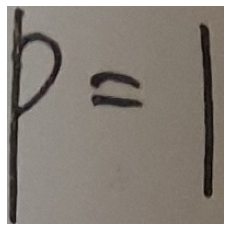

['p', '=']


In [249]:
idx, (ratio, filepath) = next(iter_)
show_image(filepath)

In [142]:
test_list = list(test_set)

In [1475]:
set_0.add(filepath) # 0
len(set_0)

234

In [2335]:
set_1.add(filepath) # 90
len(set_1)

234

In [1744]:
set_2.add(filepath) # 180
len(set_2)

234

In [1701]:
set_3.add(filepath) # -90
len(set_3)

234

In [1960]:
set_t.add(filepath)
len(set_t)

6

In [2048]:
set_r.add(filepath)
len(set_r)

85

In [2390]:
list_0 = [(p, 0) for p in set_0]
list_1 = [(p, 1) for p in set_1]
list_2 = [(p, 2) for p in set_2]
list_3 = [(p, 3) for p in set_3]

train_list = list_0 + list_1 + list_2 + list_3
valid_list = [(p, 3) for p in list(set_r)[:40]]
test_list = [(p, 3) for p in list(set_r)[40:]] + [(p, 0) for p in set_t]

random.shuffle(train_list)

In [34]:
train_all = glob(os.path.join(image_dir, "*.jpg"))

In [ ]:
test_set = set(test_list)

/opt/ml/input/data/train_dataset/images/train_39944.jpg


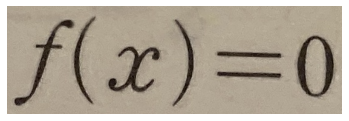

['f', '\\left(', 'x', '\\right)', '=', '0']


In [115]:
idx = random.randint(0, len(train_all) - 1)
show_image(idx)

In [116]:
filepath = idx_to_path(idx)
if (filepath, 0) not in train_list:
    test_set.add((filepath, 0))
if (filepath, 2) not in train_list:
    test_set.add((filepath, 2))
len(test_set)

156

In [118]:
len(test_set)

156

In [119]:
test_list = list(test_set)

In [143]:
with open('/opt/ml/code/notebooks/nod_train.pkl', 'wb') as f:
    pickle.dump(train_list, f)
# with open('/opt/ml/code/notebooks/nod_valid.pkl', 'wb') as f:
#     pickle.dump(valid_list, f)
with open('/opt/ml/code/notebooks/nod_test.pkl', 'wb') as f:
    pickle.dump(test_list, f)

In [144]:
with open('/opt/ml/code/notebooks/nod_train.pkl', 'rb') as f:
    train_list = pickle.load(f)
with open('/opt/ml/code/notebooks/nod_test.pkl', 'rb') as f:
    test_list = pickle.load(f)

In [145]:
len(train_list), len(test_list)

(936, 107)

In [252]:
model = timm.create_model('efficientnet_b0', pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, 4)
model.cuda()
optimizer = AdamP(list(model.parameters()), lr=5e-4)
loss_fn = nn.CrossEntropyLoss()

In [253]:
model.eval()
num_hit = 0
wrong_0 = []
correct_0 = []
for filepath, label in test_list:
    iamge = cv2.imread(filepath)
    image = cv2.cvtColor(iamge, cv2.COLOR_BGR2RGB)
    h, w, c = image.shape
    ar = w / h
    if label == 2:
        image = cv2.rotate(image, cv2.ROTATE_180)
    image = image / 255.
    image = torch.FloatTensor(image).permute(2, 0, 1).unsqueeze(0).cuda()

    with torch.no_grad():
        pred = model(image).max(-1)[-1].item()

    if label == pred:
        num_hit += 1
        correct_0.append((ar, pred))
    else:
        wrong_0.append((ar, pred, label))

print(num_hit / len(test_list))

0.38317757009345793


In [247]:
starter = torch.cuda.Event(enable_timing=True)
ender = torch.cuda.Event(enable_timing=True)

for epoch in range(10):
    model.train()
    starter.record()
    random.shuffle(train_list)
    train_loss = 0
    train_hit = 0
    for step, (filepath, label) in enumerate(train_list):
        image = cv2.imread(filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if label == 2:
            image = cv2.rotate(image, cv2.ROTATE_180)
        image = image / 255.
        image = torch.FloatTensor(image).permute(2, 0, 1).unsqueeze(0).cuda()
        
        output = model(image)
        pred = output.max(-1)[-1].item()
        
        _loss = loss_fn(output, torch.LongTensor([label]).cuda())
        model.zero_grad()
        _loss.backward()
        optimizer.step()
        
        train_loss += _loss.item()
        train_hit += int(pred == label)
        
        ender.record()
        torch.cuda.synchronize()
        dur = starter.elapsed_time(ender)
        
        print(f"\r({dur/1000:.0f}s) {(step+1)/len(train_list)*100:.0f}%", end="")

    # valid
    model.eval()
    valid_hit = 0
    valid_loss = 0
    for filepath, label in test_list:
        iamge = cv2.imread(filepath)
        image = cv2.cvtColor(iamge, cv2.COLOR_BGR2RGB)
        if label == 2:
            image = cv2.rotate(image, cv2.ROTATE_180)
        image = image / 255.
        image = torch.FloatTensor(image).permute(2, 0, 1).unsqueeze(0).cuda()

        with torch.no_grad():
            output = model(image)
        pred = output.max(-1)[-1].item()
        
        _loss = loss_fn(output, torch.LongTensor([label]).cuda())
        
        valid_loss += _loss
        valid_hit += int(label == pred)
    
    train_loss /= len(train_list)
    valid_loss /= len(test_list)
    train_acc = train_hit / len(train_list)
    valid_acc = valid_hit / len(test_list)
    print(f"\r[EPOCH {epoch+1:02d}] (train loss) {train_loss:.5f}, (train acc) {train_acc:.5f},",
          f"(valid loss) {valid_loss:.5f}, (valid acc) {valid_acc:.5f}")

[EPOCH 01] (train loss) 1.08991, (train acc) 0.41987, (valid loss) 1.20012, (valid acc) 0.73832
[EPOCH 02] (train loss) 0.91705, (train acc) 0.47329, (valid loss) 1.16365, (valid acc) 0.79439
[EPOCH 03] (train loss) 0.86124, (train acc) 0.50321, (valid loss) 1.40295, (valid acc) 0.25234
[EPOCH 04] (train loss) 0.77316, (train acc) 0.57585, (valid loss) 2.27446, (valid acc) 0.57009
[EPOCH 05] (train loss) 0.74070, (train acc) 0.61325, (valid loss) 2.49524, (valid acc) 0.29907
[EPOCH 06] (train loss) 0.63050, (train acc) 0.70620, (valid loss) 1.60696, (valid acc) 0.77570
[EPOCH 07] (train loss) 0.54087, (train acc) 0.75748, (valid loss) 1.56762, (valid acc) 0.71028
[EPOCH 08] (train loss) 0.41598, (train acc) 0.81303, (valid loss) 2.44796, (valid acc) 0.54206
[EPOCH 09] (train loss) 0.30497, (train acc) 0.88568, (valid loss) 2.40487, (valid acc) 0.69159
[EPOCH 10] (train loss) 0.25688, (train acc) 0.89530, (valid loss) 2.50409, (valid acc) 0.63551


In [ ]:
model.eval()

wrong = []
correct = []
for filepath, label in test_list:
    iamge = cv2.imread(filepath)
    image = cv2.cvtColor(iamge, cv2.COLOR_BGR2RGB)
    h, w, c = image.shape
    ar = w / h
    if label == 2:
        image = cv2.rotate(image, cv2.ROTATE_180)
    image = image / 255.
    image = torch.FloatTensor(image).permute(2, 0, 1).unsqueeze(0).cuda()

    with torch.no_grad():
        pred = model(image).max(-1)[-1].item()

    if label == pred:
        correct.append((ar, pred, label, filepath))
    else:
        wrong.append((ar, pred, label, filepath))

In [ ]:
correct_labels = [lb for _, _, lb, _ in correct]
all_labels = [lb for _, _, lb, _ in correct + wrong]
for lb in range(4):
    print(f"{correct_labels.count(lb):02d} / {all_labels.count(lb):02d}")

In [ ]:
for i in range(4):
    print(f'{i}:', [yy for _, yy, lb, _ in wrong if lb == i])

In [ ]:
for i in range(4):
    print(f'{i}:', [lb for _, yy, lb, _ in wrong if yy == i])